In [1]:
import os
import glob
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl
from matplotlib import pyplot
from matplotlib.pyplot import imshow
from matplotlib.transforms import Transform
from matplotlib.ticker import (
    AutoLocator, AutoMinorLocator)

from os import environ
os.environ["OMP_NUM_THREADS"] = "1"


import math

import csv
import urllib.request, json 
import requests
import yaml
from pymoc import MOC
import time
import numpy as np
import pyvo as vo


import igraph
from igraph import *

from fa2 import ForceAtlas2

from sklearn.cluster import spectral_clustering
from sklearn.cluster import SpectralClustering
from sklearn.cluster import KMeans
import scipy
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KDTree
from scipy.cluster.hierarchy import dendrogram, linkage

from random import randint

import networkx as nx

import pandas

from matplotlib import colors
from matplotlib import cm
import statistics

from tabulate import tabulate

In [2]:
'''0.1. Read Raw Similarity Matrix'''

#Read raw dissimilarity matrix
with open('./Dissimilar_matrix_5PCs_Gaussian.csv','r', encoding="latin-1") as chi2_file:
    data_raw = list(csv.reader(chi2_file))
chi2_file.close()

#Append into array & Invert to raw similarity matrix
raw_dissim_matrix = np.array(data_raw[:])
raw_dissim_matrix = raw_dissim_matrix.astype(np.float)
print(raw_dissim_matrix)

#similarity matrix = 1 - dissimilarity matrix
raw_sim_matrix = np.subtract(1.0,raw_dissim_matrix)
raw_sim_matrix = raw_sim_matrix.astype(np.float)

#Fill diagonal with 0 (eliminate self loops)
np.fill_diagonal(raw_sim_matrix, 0.)

print(raw_sim_matrix)



#Read names
with open('./Labels_5PCs_Gaussian.csv','r', encoding="latin-1") as names_file:
    names = list(csv.reader(names_file))
names_file.close()

galaxy_names = np.array(names[0])
print(galaxy_names)

[[0.         0.56346807 0.8007982  ... 0.83835902 1.1638433  1.13642324]
 [0.56346807 0.         0.71541066 ... 1.03240318 1.21088178 1.22564462]
 [0.8007982  0.71541066 0.         ... 1.26682762 1.34027497 1.34775419]
 ...
 [0.83835902 1.03240318 1.26682762 ... 0.         0.55563153 0.48385805]
 [1.1638433  1.21088178 1.34027497 ... 0.55563153 0.         0.27020594]
 [1.13642324 1.22564462 1.34775419 ... 0.48385805 0.27020594 0.        ]]
[[ 0.          0.43653193  0.1992018  ...  0.16164098 -0.1638433
  -0.13642324]
 [ 0.43653193  0.          0.28458934 ... -0.03240318 -0.21088178
  -0.22564462]
 [ 0.1992018   0.28458934  0.         ... -0.26682762 -0.34027497
  -0.34775419]
 ...
 [ 0.16164098 -0.03240318 -0.26682762 ...  0.          0.44436847
   0.51614195]
 [-0.1638433  -0.21088178 -0.34027497 ...  0.44436847  0.
   0.72979406]
 [-0.13642324 -0.22564462 -0.34775419 ...  0.51614195  0.72979406
   0.        ]]
['IRAS05189-2524.txt' 'IRAS08572+3915.txt' 'IRAS12112+0305.txt'
 'IRAS143

In [3]:
'''1. Read Gramian Matrix (sigma = std) as Affinity Matrix (raw similarity matrix)'''


#Read KPCA Similarity Matrix as Affinity Matrix (gamma=0.0163)
with open('./Gramian_(Gaussian_sigma_=_std).csv','r', encoding="latin-1") as chi2_file:
    data_KPCA = list(csv.reader(chi2_file))
chi2_file.close()
#Append into array & Convert to raw similarity matrix
KPCA_affinity_matrix = np.array(data_KPCA[:])
KPCA_affinity_matrix = KPCA_affinity_matrix.astype(np.float)

#Fill diagonal with 0 (eliminate self loops)
#np.fill_diagonal(KPCA_affinity_matrix, 0.)

print(KPCA_affinity_matrix)


#Read names
with open('./Labels_5PCs_Gaussian.csv','r', encoding="latin-1") as names_file:
    names = list(csv.reader(names_file))
names_file.close()

galaxy_names = np.array(names[0])
print(galaxy_names)

labels_list=[]
for i,val in enumerate(galaxy_names):
    labels_list.append([i+1, val])

np.savetxt("labels_list.csv", labels_list, delimiter=",", fmt="%s")

[[0.         0.64995088 0.4290214  ... 0.38273516 0.09545473 0.09685582]
 [0.64995088 0.         0.48125863 ... 0.17894874 0.05119499 0.0367408 ]
 [0.4290214  0.48125863 0.         ... 0.03331116 0.00456456 0.0034383 ]
 ...
 [0.38273516 0.17894874 0.03331116 ... 0.         0.64970942 0.71709946]
 [0.09545473 0.05119499 0.00456456 ... 0.64970942 0.         0.83394941]
 [0.09685582 0.0367408  0.0034383  ... 0.71709946 0.83394941 0.        ]]
['IRAS05189-2524.txt' 'IRAS08572+3915.txt' 'IRAS12112+0305.txt'
 'IRAS14348-1447.txt' 'IRAS15250+3609.txt' 'IRAS22491-1808.txt'
 'Arp220.txt' 'Mrk231.txt' 'Mrk273.txt' 'UGC 5101.txt'
 'IRAS F00183-7111.txt' 'IRAS00188-0856.txt' 'IRAS00199-7426.txt'
 'IRAS00275-0044.txt' 'IRAS00275-2859.txt' 'IRAS00397-1312.txt'
 'IRAS00406-3127.txt' 'IRAS01003-2238.txt' 'IRAS01199-2307.txt'
 'IRAS01298-0744.txt' 'IRAS01355-1814.txt' 'IRAS01388-4618.txt'
 'IRAS01494-1845.txt' 'IRAS02054+0835.txt' 'IRAS02113-2937.txt'
 'IRAS02115+0226.txt' 'IRAS02455-2220.txt' 'IRAS025

In [4]:
'''2. Manual Calculation of Weighted Adjacency Matrix from raw similarity matrix:
Keep only edges with 6 biggest weights for each node of Affinity Matrix (=raw similarity matrix)'''

#Take each line of Affinity Matrix, sort descending, take 6th value. 
#If value in Affinity matrix is lower than that value, then replace with 0.0.

Adjacency_matrix_ = np.empty((0,139),float)

for row in KPCA_affinity_matrix:
    #Sort descending + take 6th biggest weight
    affinity_row_sorted = np.sort(row)[::-1]
    sixth_element = affinity_row_sorted[6] #First element is always diagonal = 1
    #If each value in row is lower than 6th biggest weight, set = 0.0
    row = np.where(row < sixth_element, 0.0, row)
    #Add each filtered row to new Adjacency Matrix
    
    Adjacency_matrix_ = np.vstack([Adjacency_matrix_, row])


#Fill diagonal with 0.0 (no self loops)
np.fill_diagonal(Adjacency_matrix_, 0.0)

#Make matrix Symmetric (keep highest value)
Adjacency_matrix = np.maximum(Adjacency_matrix_, Adjacency_matrix_.transpose())

print(Adjacency_matrix)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


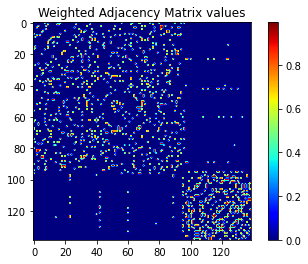

In [5]:
#Plot heat map of Adjacency matrix
pyplot.imshow(Adjacency_matrix, cmap='jet')
pyplot.colorbar()
#pyplot.clim(0, 1);
pyplot.title("Weighted Adjacency Matrix values")
pyplot.show()

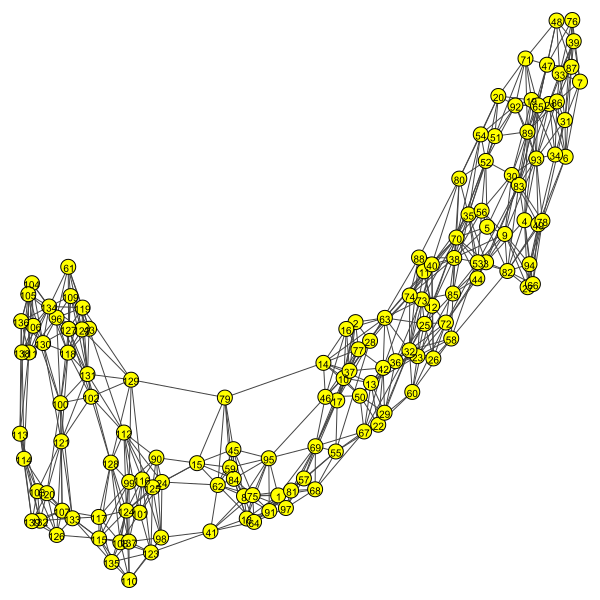

In [6]:
'''3. Create graph with similarity matrix = Adjacency Matrix'''

Adjacency_matrix_list = Adjacency_matrix.tolist()

Farrah_PG_adjacency_graph = Graph.Weighted_Adjacency(Adjacency_matrix_list, ADJ_MAX)

Farrah_PG_adjacency_graph.vs["name"] = [i[0] for i in labels_list]
Farrah_PG_adjacency_graph.vs["label"] = Farrah_PG_adjacency_graph.vs["name"]
Farrah_PG_adjacency_graph.vs["label_size"] = 10
Farrah_PG_adjacency_graph.vs["color"] = "yellow"

out_name = "5PCs_Farrah_PG_Adjacency_graph_k=6.png"
plot(Farrah_PG_adjacency_graph, out_name, vertex_size = 15)

------------------
Network diameter =  13
------------------
Average degree of graph =  9.309352517985614
Minimum degree of graph =  7
Maximum degree of graph =  18
------------------
Network clustering coefficient =  0.5210276262537392
------------------
Clustering coefficient of archetypical galaxies:
Arp 220 (7) =  0.6067884679434222
IRAS 17068+4027 (74) =  0.5213278302344723
IRAS 00275-2859 (15) =  0.7563358434022901
IRAS 17179+5444 (75) =  0.71861847125882
PG 0934+013 (116) =  0.6085434036982216
3C 273 (96) =  0.7164954324495886
------------------


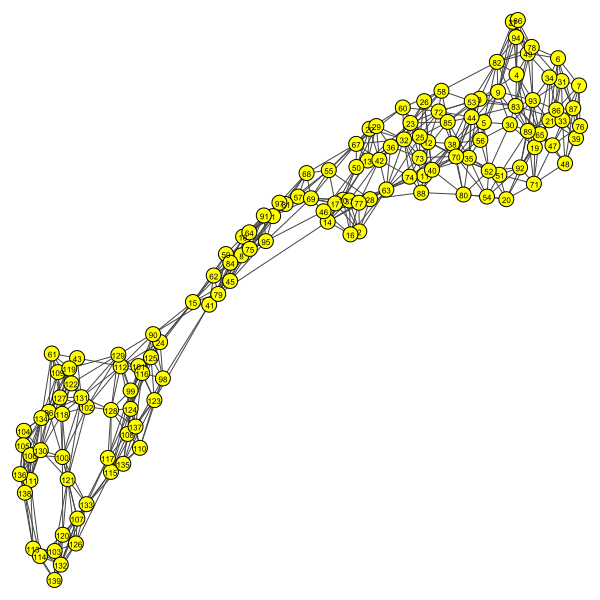

In [7]:
'''4. Spring-type layout (Force Atlas 2, Kamada-Kawai or Fruchterman Reingold)'''

#Convert to Normalized Laplacian
#L = Farrah_PG_graph.laplacian(normalized=True)

#similarity_matrix_list = similarity_matrix.tolist()
#Create graph with similiratity matrix = edge weights
#Farrah_PG_graph = Graph.Weighted_Adjacency(similarity_matrix_list, mode=ADJ_UNDIRECTED, attr='weight', loops=False)

#Kamada-Kawai force-directed algorithm layout
#visual_style = {}
#layout = Farrah_PG_graph.layout_kamada_kawai()
#visual_style["layout"] = layout


#Try Force Atlas 2 layout

# Create ForceAtlas2 object with desired parameters
forceatlas2 = ForceAtlas2(
                          # Behavior alternatives
                          outboundAttractionDistribution=True,  # Dissuade hubs
                          linLogMode=False,  # NOT IMPLEMENTED
                          adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=True,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=2.0,
                          strongGravityMode=False,
                          gravity=1.0,

                          # Log
                          verbose=True)


#**********IMPLEMENT FORCE ATLAS ON chi^2 SIMILARITY MATRIX**********
#layout = forceatlas2.forceatlas2_igraph_layout(Farrah_PG_graph, pos=None, iterations=1000, weight_attr='weight')


#**********IMPLEMENT FORCE ATLAS ON NEW ADJACENCY MATRIX**********
#layout = forceatlas2.forceatlas2_igraph_layout(Farrah_PG_adjacency_graph, pos=None, iterations=10000, weight_attr='weight')



#*****OTHER OPTIONAL LAYOUTS*****
#Kamada Kawai layout:
#layout = Farrah_PG_adjacency_graph.layout("kamada_kawai")

#Fruchterman Reingold layout:
layout = Farrah_PG_adjacency_graph.layout("fruchterman_reingold", weights=Farrah_PG_adjacency_graph.es['weight'])

#print(layout[:]) #Save as excel using pandas to save a good layout!

#     ************    UNCOMMENT BELOW TO SAVE A NEW CUSTOM LAYOUT    ************
#layout_positions = pandas.DataFrame(layout[:], columns=['x','y'])
#layout_positions.to_excel('layout_positions_fr.xlsx', sheet_name='layout_positions')
df = pandas.read_excel('layout_positions_fr.xlsx', sheet_name='layout_positions', usecols="B,C")
custom_layout = df.values.tolist()

# G is an igraph graph
# pos is a numpy array (Nx2) or list of initial positions of nodes (see that the indexing matches igraph node index)
# iterations is num of iterations to run the algorithm
# weight_attr denotes the weight attribute's name in G.es, None by default
# returns an igraph layout


#Galaxy names
Farrah_PG_adjacency_graph.vs["name"] = [i[0] for i in labels_list]
Farrah_PG_adjacency_graph.vs["label"] = Farrah_PG_adjacency_graph.vs["name"]
Farrah_PG_adjacency_graph.vs["label_size"] = 8
Farrah_PG_adjacency_graph.vs["color"] = 'yellow'


#Manual threshold value:    
#threshold_value=0.1
#Farrah_PG_graph.es.select(weight_lt=threshold_value).delete()
#print('Threshold value: ', threshold_value)


#threshold_value=0.0001
#new_graph = Farrah_PG_graph
#Find maximum threshold value to filter graph before plotting & analysis
#while (new_graph.is_connected()==True):
#    max_threshold_value=threshold_value-0.0001
#    threshold_value+=0.0001
#    new_graph.es.select(weight_lt=threshold_value).delete()
#else:
#    #Delete edges with weights < maximum threshold of connected graph
#    Farrah_PG_graph.es.select(weight_lt=max_threshold_value).delete()

#print('------------------')    
#print('Maximum threshold value:', max_threshold_value)



#knn Analysis
#knn = Farrah_PG_graph.knn()
avg_degree = mean(Farrah_PG_adjacency_graph.degree(loops=False))
min_degree = min(Farrah_PG_adjacency_graph.degree(loops=False))
max_degree = max(Farrah_PG_adjacency_graph.degree(loops=False))
network_diameter = Farrah_PG_adjacency_graph.diameter(directed=False)
clustering_coefficient = Farrah_PG_adjacency_graph.transitivity_undirected()
#Calculate local clustering coefficient of each archetypical galaxy examined:
clustering_coefficient_7 = Farrah_PG_adjacency_graph.transitivity_local_undirected(vertices=7, weights=Farrah_PG_adjacency_graph.es['weight'])
clustering_coefficient_74 = Farrah_PG_adjacency_graph.transitivity_local_undirected(vertices=74, weights=Farrah_PG_adjacency_graph.es['weight'])
clustering_coefficient_15 = Farrah_PG_adjacency_graph.transitivity_local_undirected(vertices=15, weights=Farrah_PG_adjacency_graph.es['weight'])
clustering_coefficient_75 = Farrah_PG_adjacency_graph.transitivity_local_undirected(vertices=75, weights=Farrah_PG_adjacency_graph.es['weight'])
clustering_coefficient_116 = Farrah_PG_adjacency_graph.transitivity_local_undirected(vertices=116, weights=Farrah_PG_adjacency_graph.es['weight'])
clustering_coefficient_96 = Farrah_PG_adjacency_graph.transitivity_local_undirected(vertices=96, weights=Farrah_PG_adjacency_graph.es['weight'])
#print('------------------')
#print('knn - average degree of neighbors for each vertex: ')
#print('------------------')
#print(knn[0])
#print('------------------')
#print('knn - average degree of neighbors as a function of vertex degree: ')
#print('------------------')
#print(knn[1])
print('------------------')
print('Network diameter = ', network_diameter)
print('------------------')
print('Average degree of graph = ', avg_degree)
print('Minimum degree of graph = ', min_degree)
print('Maximum degree of graph = ', max_degree)
print('------------------')
print('Network clustering coefficient = ', clustering_coefficient)
print('------------------')
print('Clustering coefficient of archetypical galaxies:')
print('Arp 220 (7) = ', clustering_coefficient_7)
print('IRAS 17068+4027 (74) = ', clustering_coefficient_74)
print('IRAS 00275-2859 (15) = ', clustering_coefficient_15)
print('IRAS 17179+5444 (75) = ', clustering_coefficient_75)
print('PG 0934+013 (116) = ', clustering_coefficient_116)
print('3C 273 (96) = ', clustering_coefficient_96)
print('------------------')

#Set colors for clustering analysis
color_list = ['cyan','red','yellow','green','orange','pink','gray', 'violet', 'purple', 'palegreen', 'skyblue', 'dodgerblue',]
#Get list of n random colors
#color_list = []
#n = 143
#for i in range(n):
#    color_list.append('#%06X' % randint(0, 0xFFFFFF))

    
    
#print(len(Farrah_PG_adjacency_graph.es))
    
#Plot    
out_name = "5PCs_Farrah_PG_fr_layout.png"
igraph.plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)


------------------
Louvain algorithm:
------------------
------------------
Number of communities:  6
Modularity score =  0.6974439367131324
------------------
Conductance per cluster: [0.10994793759722389, 0.22098115504261895, 0.20790545035493138, 0.09064257815504362, 0.11886705458325861, 0.05231037245895387]
Max Conductance =  0.22098115504261895
Cluster with max conductance color =  red
Louvain clusters =  [0, 1, 2, 3, 2, 3, 3, 0, 3, 1, 2, 2, 1, 1, 0, 1, 1, 0, 3, 3, 3, 1, 2, 4, 2, 2, 3, 1, 1, 3, 3, 2, 3, 3, 2, 1, 1, 2, 3, 2, 0, 1, 5, 2, 0, 1, 3, 3, 3, 1, 3, 3, 2, 3, 0, 2, 0, 2, 0, 2, 5, 0, 1, 0, 3, 3, 1, 0, 0, 2, 3, 2, 2, 2, 0, 3, 1, 3, 0, 2, 0, 3, 3, 0, 2, 3, 3, 2, 3, 4, 0, 3, 3, 3, 0, 5, 0, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5]


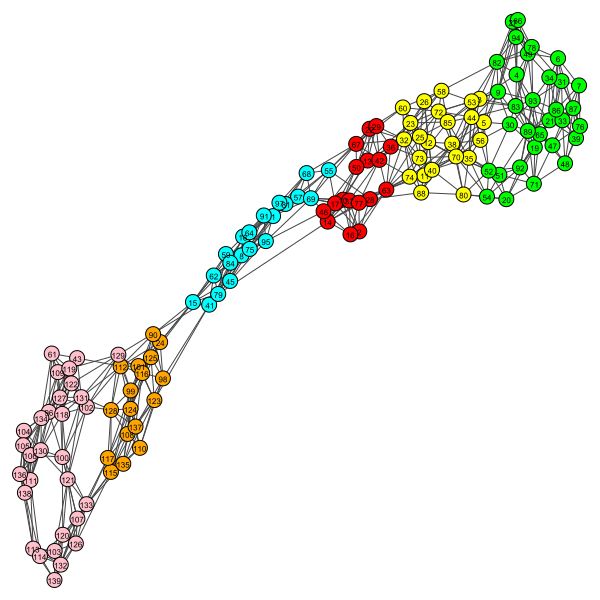

In [8]:
'''5. Clustering algorithms '''
'''5.1 Louvain algorithm'''

print('------------------')
print('Louvain algorithm:')
print('------------------')
print('------------------')
communities = Farrah_PG_adjacency_graph.community_multilevel(weights=Farrah_PG_adjacency_graph.es['weight'])
print('Number of communities: ', max(communities.membership)+1)
print('Modularity score = ',communities.modularity)
      
Modularity_array = np.zeros(shape=(7,3), dtype=object)
Modularity_array[0] = [str('Louvain'), int(max(communities.membership)+1), float(communities.modularity)]

Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in communities.membership]

#Get conductance value
conductance=[]
for cluster in communities:
        graph_nx = Farrah_PG_adjacency_graph.to_networkx()
        try:
            conductance.append(nx.conductance(graph_nx, cluster, weight='weight'))
        except:
            conductance.append(1)
max_conductance = np.max(conductance)
max_conductance_index = conductance.index(max_conductance)
print('------------------')
print('Conductance per cluster:', conductance)
print('Max Conductance = ', max_conductance)
print('Cluster with max conductance color = ', color_list[max_conductance_index])

Conductance_array = np.zeros(shape=(7,3), dtype=object)
Conductance_array[0] = [str('Louvain'), int(max(communities.membership)+1), float(max_conductance)]

Louvain_clusters=communities.membership
print('Louvain clusters = ',Louvain_clusters)

out_name = "5PCs_Farrah_PG_Blondel(Louvain).png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)


------------------
Girvan-Newman Edge Betweenness algorithm:
------------------
Number of communities:  6
Modularity score =  0.6965437914617221
------------------
Conductance per cluster: [0.10994793759722389, 0.22098115504261895, 0.1886772365357109, 0.0922185721984065, 0.12995828392773887, 0.06511167448121884]
Max Conductance =  0.22098115504261895
Cluster with max conductance color =  red
Girvan-Newman clusters =  [0, 1, 2, 3, 2, 3, 3, 0, 3, 1, 2, 2, 1, 1, 0, 1, 1, 0, 3, 3, 3, 1, 2, 4, 2, 2, 3, 1, 1, 3, 3, 2, 3, 3, 2, 1, 1, 2, 3, 2, 0, 1, 5, 2, 0, 1, 3, 3, 3, 1, 3, 2, 2, 2, 0, 2, 0, 2, 0, 2, 5, 0, 1, 0, 3, 3, 1, 0, 0, 2, 3, 2, 2, 2, 0, 3, 1, 3, 0, 2, 0, 3, 3, 0, 2, 3, 3, 2, 3, 4, 0, 3, 3, 3, 0, 5, 0, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 4, 5, 4, 5, 4, 5, 5]


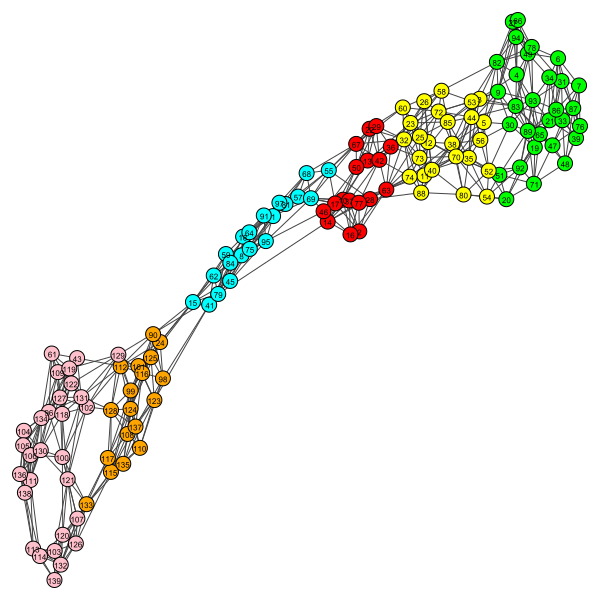

In [9]:
'''5.2.a Girvan-Newman: Edge Betweenness'''
print('------------------')
print('Girvan-Newman Edge Betweenness algorithm:')
print('------------------')
communities = Farrah_PG_adjacency_graph.community_edge_betweenness(directed=False)
clusters = communities.as_clustering()
print('Number of communities: ', max(clusters.membership)+1)
print('Modularity score = ', clusters.modularity)

Girvan_Newman_modularity_array = np.array([str('Girvan-Newman'), int(max(clusters.membership)+1), float(clusters.modularity)], dtype=object)
Modularity_array[1] = Girvan_Newman_modularity_array

Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in clusters.membership]

#Get conductance value
conductance=[]
for cluster in clusters:
        graph_nx = Farrah_PG_adjacency_graph.to_networkx()
        try:
            conductance.append(nx.conductance(graph_nx, cluster, weight='weight'))
        except:
            conductance.append(1)
max_conductance = np.max(conductance)
max_conductance_index = conductance.index(max_conductance)
print('------------------')
print('Conductance per cluster:', conductance)
print('Max Conductance = ', max_conductance)
print('Cluster with max conductance color = ', color_list[max_conductance_index])

Girvan_Newman_conductance_array = np.array([str('Girvan-Newman'), int(max(clusters.membership)+1), float(max_conductance)], dtype=object)
Conductance_array[1] = Girvan_Newman_conductance_array

Girvan_Newman_clusters=clusters.membership
print('Girvan-Newman clusters = ',Girvan_Newman_clusters)

out_name = "5PCs_Farrah_PG_Girvan-Newman.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
Girvan-Newman Edge Betweenness algorithm:
------------------
Number of communities:  4
Modularity score =  0.6426121108545163
------------------
Conductance per cluster: [0.13919150999923452, 0.10627452499276023, 0.09393909119152076, 0.013687739745871105]
Max Conductance =  0.13919150999923452
Cluster with max conductance color =  cyan


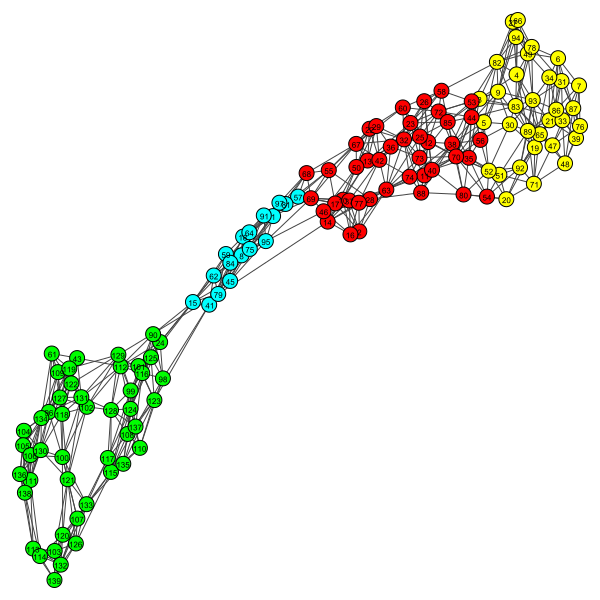

In [10]:
'''5.2.b Girvan-Newman: Edge Betweenness --- WITH REQUIREMENT THAT CLUSTERS = 4'''
print('------------------')
print('Girvan-Newman Edge Betweenness algorithm:')
print('------------------')
communities = Farrah_PG_adjacency_graph.community_edge_betweenness(clusters=4, directed=False, weights=Farrah_PG_adjacency_graph.es['weight'])
clusters = communities.as_clustering()
print('Number of communities: ', max(clusters.membership)+1)
print('Modularity score = ', clusters.modularity)

Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in clusters.membership]

#Get conductance value
conductance=[]
for cluster in clusters:
        graph_nx = Farrah_PG_adjacency_graph.to_networkx()
        try:
            conductance.append(nx.conductance(graph_nx, cluster, weight='weight'))
        except:
            conductance.append(1)
max_conductance = np.max(conductance)
max_conductance_index = conductance.index(max_conductance)
print('------------------')
print('Conductance per cluster:', conductance)
print('Max Conductance = ', max_conductance)
print('Cluster with max conductance color = ', color_list[max_conductance_index])

out_name = "5PCs_Farrah_PG_Girvan-Newman_4clusters.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
LEIDEN algorithm:
------------------
Number of communities:  6
Resolution parameter (for max modularity) = 1.0
Modularity score =  0.6970102890155834
------------------
Conductance per cluster: [0.10994793759722389, 0.2879560007477289, 0.12430770205740613, 0.09393505039369775, 0.11886705458325861, 0.05231037245895387]
Max Conductance =  0.2879560007477289
Cluster with max conductance color =  red
Leiden clusters =  [0, 1, 2, 3, 2, 3, 3, 0, 3, 1, 2, 2, 2, 1, 0, 1, 1, 0, 3, 2, 3, 2, 2, 4, 2, 2, 3, 1, 2, 3, 3, 2, 3, 3, 2, 2, 1, 2, 3, 2, 0, 2, 5, 2, 0, 1, 3, 3, 3, 2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 5, 0, 2, 0, 3, 3, 2, 0, 0, 2, 3, 2, 2, 2, 0, 3, 1, 3, 0, 2, 0, 3, 3, 0, 2, 3, 3, 2, 3, 4, 0, 3, 3, 3, 0, 5, 0, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5]


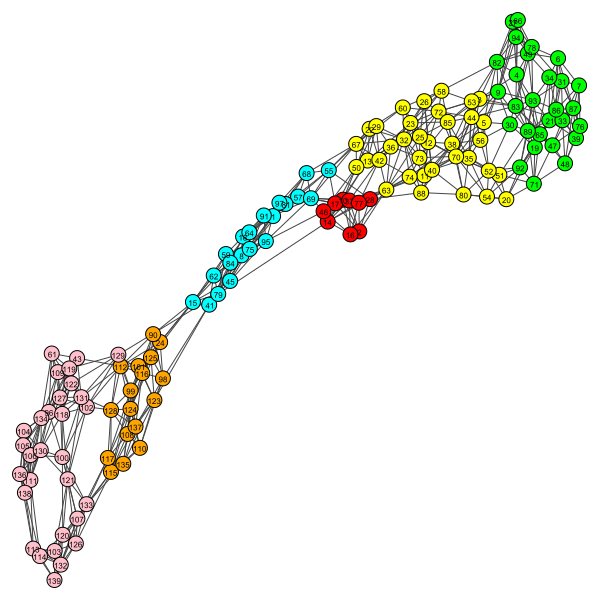

In [11]:
'''5.3 Leiden algorithm'''
print('------------------')
print('LEIDEN algorithm:')
print('------------------')

#objective_function = sets highest modularity as target
#resolution_parameter = sets resolution (higher = more communities)
communities = Farrah_PG_adjacency_graph.community_leiden(objective_function='modularity',weights=Farrah_PG_adjacency_graph.es['weight'], resolution_parameter=1.0)
print('Number of communities: ', max(communities.membership)+1)
print('Resolution parameter (for max modularity) = 1.0')
print('Modularity score = ',communities.modularity)
leiden_labels = communities.membership

Leiden_modularity_array = np.array([str('Leiden'), int(max(communities.membership)+1), float(communities.modularity)], dtype=object)
Modularity_array[2] = Leiden_modularity_array

Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in communities.membership]

#Get conductance value
conductance=[]
for cluster in communities:
        graph_nx = Farrah_PG_adjacency_graph.to_networkx()
        try:
            conductance.append(nx.conductance(graph_nx, cluster, weight='weight'))
        except:
            conductance.append(1)
max_conductance = np.max(conductance)
max_conductance_index = conductance.index(max_conductance)
print('------------------')
print('Conductance per cluster:', conductance)
print('Max Conductance = ', max_conductance)
print('Cluster with max conductance color = ', color_list[max_conductance_index])

Leiden_conductance_array = np.array([str('Leiden'), int(max(communities.membership)+1), float(max_conductance)], dtype=object)
Conductance_array[2] = Leiden_conductance_array

leiden_labels = communities.membership
print('Leiden clusters = ',leiden_labels)

out_name = "5PCs_Farrah_PG_Leiden.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
NEWMAN - Leading Eigenvector algorithm:
------------------
Number of communities:  6
Modularity score =  0.6711224903470854
------------------
Conductance per cluster: [0.21885725375647402, 0.16140841126231867, 0.22885569990778815, 0.21598310205652005, 0.09495319882508414, 0.06812191958813045]
Max Conductance =  0.22885569990778815
Cluster with max conductance color =  yellow
Newman clusters =  [0, 3, 2, 4, 2, 4, 4, 0, 4, 3, 2, 2, 3, 3, 1, 3, 3, 0, 4, 4, 4, 3, 2, 1, 2, 2, 4, 3, 3, 4, 4, 3, 4, 4, 2, 3, 3, 2, 4, 2, 1, 3, 5, 2, 0, 3, 4, 4, 4, 3, 2, 2, 2, 2, 3, 2, 0, 2, 1, 3, 5, 1, 3, 0, 4, 4, 3, 0, 0, 2, 4, 2, 2, 2, 0, 4, 3, 4, 1, 2, 0, 4, 4, 0, 2, 4, 4, 2, 4, 1, 0, 4, 4, 4, 0, 5, 0, 1, 1, 5, 1, 5, 5, 5, 5, 5, 5, 1, 5, 1, 5, 1, 5, 5, 1, 1, 1, 5, 5, 5, 5, 5, 1, 1, 1, 5, 5, 1, 1, 5, 5, 5, 1, 5, 1, 5, 1, 5, 5]


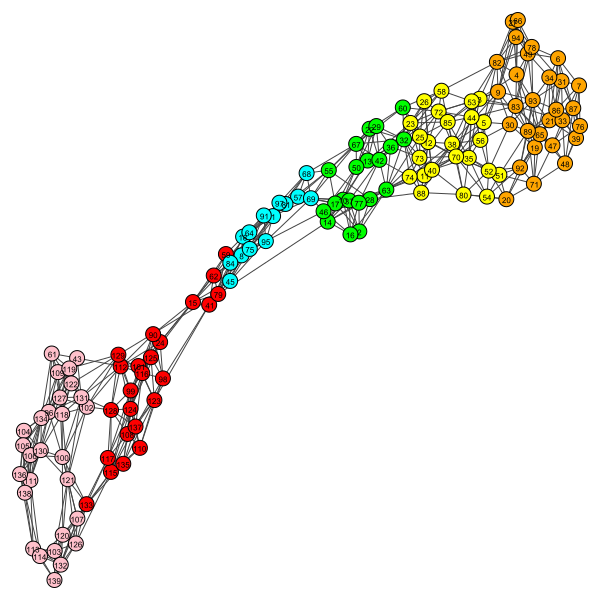

In [12]:
'''5.4.a Newman algorithm'''
print('------------------')
print('NEWMAN - Leading Eigenvector algorithm:')
print('------------------')
communities = Farrah_PG_adjacency_graph.community_leading_eigenvector(weights=Farrah_PG_adjacency_graph.es['weight'])
print('Number of communities: ', max(communities.membership)+1)
print('Modularity score = ',communities.modularity)

Newman_modularity_array = np.array([str('Newman'), int(max(communities.membership)+1), float(communities.modularity)], dtype=object)
Modularity_array[3] = Newman_modularity_array

Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in communities.membership]

#Get conductance value
conductance=[]
for cluster in communities:
        graph_nx = Farrah_PG_adjacency_graph.to_networkx()
        try:
            conductance.append(nx.conductance(graph_nx, cluster, weight='weight'))
        except:
            conductance.append(1)
max_conductance = np.max(conductance)
max_conductance_index = conductance.index(max_conductance)
print('------------------')
print('Conductance per cluster:', conductance)
print('Max Conductance = ', max_conductance)
print('Cluster with max conductance color = ', color_list[max_conductance_index])

Newman_conductance_array = np.array([str('Newman'), int(max(communities.membership)+1), float(max_conductance)], dtype=object)
Conductance_array[3] = Newman_conductance_array

Newman_clusters=communities.membership
print('Newman clusters = ',Newman_clusters)

out_name = "5PCs_Farrah_PG_Newman.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
NEWMAN - Leading Eigenvector algorithm:
------------------
Number of communities:  4
Modularity score =  0.5959677123235158
------------------
Conductance per cluster: [0.21885725375647402, 0.03435676775276896, 0.05477527654968731, 0.21598310205652005]
Max Conductance =  0.21885725375647402
Cluster with max conductance color =  cyan


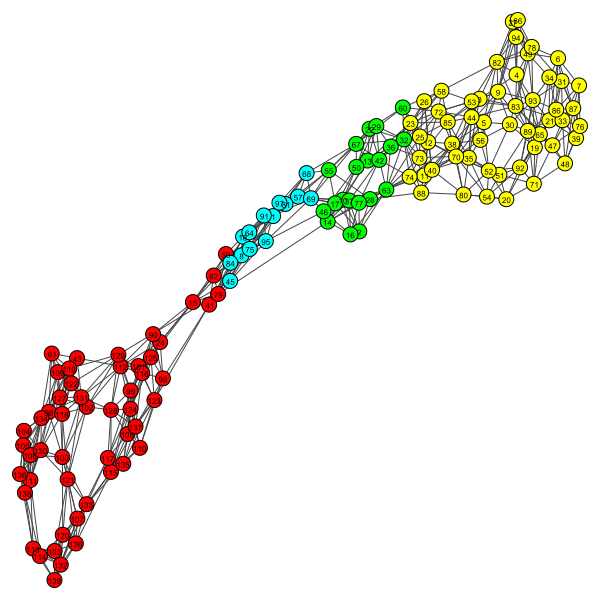

In [13]:
'''5.4.b Newman algorithm --- WITH REQUIREMENT THAT CLUSTERS = 4'''
print('------------------')
print('NEWMAN - Leading Eigenvector algorithm:')
print('------------------')
communities = Farrah_PG_adjacency_graph.community_leading_eigenvector(clusters=4, weights=Farrah_PG_adjacency_graph.es['weight'])
print('Number of communities: ', max(communities.membership)+1)
print('Modularity score = ',communities.modularity)
Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in communities.membership]

#Get conductance value
conductance=[]
for cluster in communities:
        graph_nx = Farrah_PG_adjacency_graph.to_networkx()
        try:
            conductance.append(nx.conductance(graph_nx, cluster, weight='weight'))
        except:
            conductance.append(1)
max_conductance = np.max(conductance)
max_conductance_index = conductance.index(max_conductance)
print('------------------')
print('Conductance per cluster:', conductance)
print('Max Conductance = ', max_conductance)
print('Cluster with max conductance color = ', color_list[max_conductance_index])



out_name = "5PCs_Farrah_PG_Newman_4clusters.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
Walktrap algorithm:
------------------
Number of walktrap steps (for max modularity): 30
Number of communities:  6
Modularity score =  0.7012495882156984
------------------
Conductance per cluster: [0.11586701852742635, 0.21039943345138076, 0.17431105156103816, 0.09393505039369775, 0.12360268173068405, 0.0548720231234844]
Max Conductance =  0.21039943345138076
Cluster with max conductance color =  red
Walktrap clusters =  [0, 1, 2, 3, 2, 3, 3, 0, 3, 1, 2, 2, 1, 1, 0, 1, 1, 0, 3, 2, 3, 1, 2, 4, 2, 2, 3, 1, 1, 3, 3, 2, 3, 3, 2, 1, 1, 2, 3, 2, 0, 1, 5, 2, 0, 1, 3, 3, 3, 1, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 5, 0, 1, 0, 3, 3, 1, 0, 0, 2, 3, 2, 2, 2, 0, 3, 1, 3, 0, 2, 0, 3, 3, 0, 2, 3, 3, 2, 3, 4, 0, 3, 3, 3, 0, 5, 0, 4, 4, 5, 4, 5, 5, 5, 5, 5, 5, 4, 5, 4, 5, 4, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5, 4, 4, 5, 5, 5, 5, 5, 4, 5, 4, 5, 5]


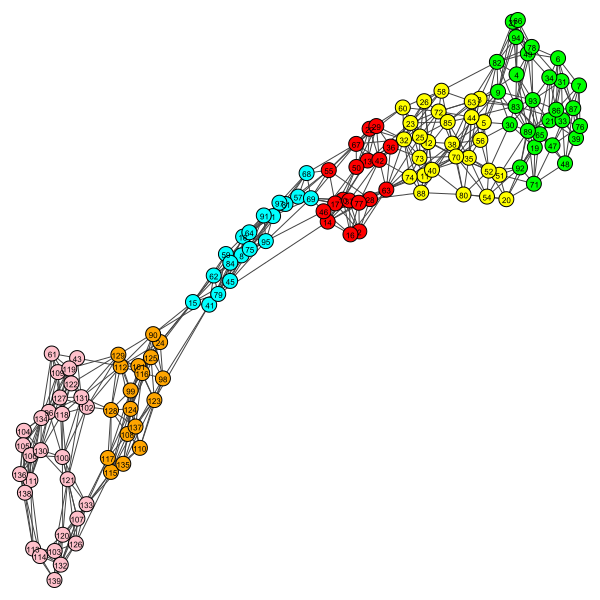

In [14]:
'''5.5 Walktrap algorithm --- Community detection algorithm of Latapy & Pons, based on random walks'''

print('------------------')
print('Walktrap algorithm:')
print('------------------')
communities = Farrah_PG_adjacency_graph.community_walktrap(weights=Farrah_PG_adjacency_graph.es['weight'], steps = 30)
clusters = communities.as_clustering()
print('Number of walktrap steps (for max modularity): 30')
print('Number of communities: ', max(clusters.membership)+1)
print('Modularity score = ', clusters.modularity)
Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in clusters.membership]

Walktrap_modularity_array = np.array([str('Walktrap'), int(max(clusters.membership)+1), float(clusters.modularity)], dtype=object)
Modularity_array[4] = Walktrap_modularity_array

#Get conductance value
conductance=[]
for cluster in clusters:
        graph_nx = Farrah_PG_adjacency_graph.to_networkx()
        try:
            conductance.append(nx.conductance(graph_nx, cluster, weight='weight'))
        except:
            conductance.append(1)
max_conductance = np.max(conductance)
max_conductance_index = conductance.index(max_conductance)
print('------------------')
print('Conductance per cluster:', conductance)
print('Max Conductance = ', max_conductance)
print('Cluster with max conductance color = ', color_list[max_conductance_index])

Walktrap_conductance_array = np.array([str('Walktrap'), int(max(clusters.membership)+1), float(max_conductance)], dtype=object)
Conductance_array[4] = Walktrap_conductance_array

Walktrap_clusters=clusters.membership
print('Walktrap clusters = ',Walktrap_clusters)

out_name = "5PCs_Farrah_PG_Walktrap.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
Minimum Spanning Tree based on previous algorithm (Walktrap):
------------------


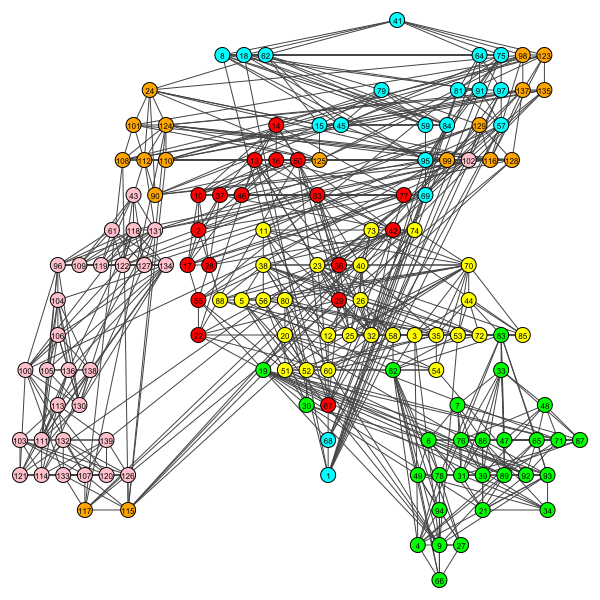

In [15]:
#Minimum Spanning Tree --- Calculates the minimum spanning tree of the graph

print('------------------')
print('Minimum Spanning Tree based on previous algorithm (Walktrap):')
print('------------------')

tree = Farrah_PG_adjacency_graph.spanning_tree(weights=Farrah_PG_adjacency_graph.es['weight'])

out_name = "5PCs_Farrah_PG_Spanning_Tree.png"
#Use Reingold-Tilford tree layout from here: https://igraph.org/python/tutorial/0.9.8/tutorial.html#layout-algorithms
plot(Farrah_PG_adjacency_graph, out_name, layout=tree.layout('tree'), vertex_size = 15)

OpenMP Number of threads: 1


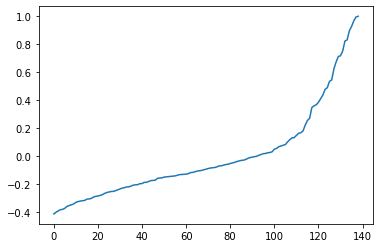

Eigenvalues of L: [-4.10405010e-01 -3.98567056e-01 -3.89147910e-01 -3.79982629e-01
 -3.78034823e-01 -3.69936988e-01 -3.56677317e-01 -3.50498915e-01
 -3.45494128e-01 -3.39086104e-01 -3.27784944e-01 -3.22241874e-01
 -3.19153393e-01 -3.16044944e-01 -3.14482590e-01 -3.05133939e-01
 -3.03452304e-01 -2.99878333e-01 -2.90431199e-01 -2.85102240e-01
 -2.82763023e-01 -2.78422113e-01 -2.73081829e-01 -2.64626918e-01
 -2.57764489e-01 -2.54141667e-01 -2.50455179e-01 -2.49521015e-01
 -2.44759825e-01 -2.38984758e-01 -2.32459611e-01 -2.25935147e-01
 -2.23361619e-01 -2.18055556e-01 -2.17075451e-01 -2.11613136e-01
 -2.05304727e-01 -2.02951002e-01 -2.01829871e-01 -1.94760626e-01
 -1.93922238e-01 -1.85517364e-01 -1.85045096e-01 -1.78838495e-01
 -1.72915642e-01 -1.71487134e-01 -1.69777720e-01 -1.56909081e-01
 -1.54171762e-01 -1.53337139e-01 -1.47723213e-01 -1.45951449e-01
 -1.44552290e-01 -1.42822064e-01 -1.40434492e-01 -1.39191865e-01
 -1.35014601e-01 -1.30137422e-01 -1.29019115e-01 -1.27965831e-01
 -1.268

In [16]:
'''
Andrew Y. Ng Spectral Clustering algorithm: K-eigenvector algorithm (line 9-12 from link below):
https://github.com/bionascu/graph-spectra/blob/master/graph-spectra.ipynb
'''

#Set number of threads = 1 to prevent overflow error
os.environ["OMP_NUM_THREADS"] = "1"
print('OpenMP Number of threads:', os.environ["OMP_NUM_THREADS"])


# Construct diagonal matrix D of Affinity matrix
D = np.diag(np.sum(Adjacency_matrix, axis=1))

# Construct the matrix L (called normalized laplacian)
D_ = np.linalg.inv(np.sqrt(D))

#L = D^[-1/2] * (D - Affinity matrix) * D^[-1/2]:
#L = np.dot(np.dot(D_, np.subtract(D,KPCA_affinity_matrix)), D_) 

#L = D^[-1/2] * (I - Affinity matrix) * D^[-1/2]:
L = np.dot(np.dot(D_, Adjacency_matrix), D_)

# Extract the eignevalues (ascending order) and normalized (unit “length”) eigenvectors of L 
w, v = scipy.linalg.eigh(L)
pyplot.plot(w)
pyplot.show()

# Print Eigenvalues & Eigenvectors of L to check
print('Eigenvalues of L:', w)
print('Normalized Eigenvectors of L:', v)
# Save Eigenvalues of L
np.savetxt('L_eigenvalues.csv', w, delimiter=',')

# Find optimal k (where the eigenvalues start dropping)
#k = np.argmin(np.ediff1d(np.flipud(w))) + 1
#print('Optimal k = %d.' % k)

k = 5 #Manual number of clusters
print('Number of clusters =', k)

# Extract k largest eigenvectors
X = v[:, Adjacency_matrix.shape[0] - k:]

# Construct matrix Y by renormalizing X
Y = np.divide(X, np.reshape(np.linalg.norm(X, axis=1), (X.shape[0], 1)))

# Cluster rows of Y into k clusters using K-means 
kmeans2 = KMeans(n_clusters=k, random_state=1234).fit(Y)

# Assign original point i to the cluster of the row i of matrix Y
cluster_labels2 = kmeans2.labels_
print(cluster_labels2)

------------------
Conductance per cluster: [0.049999999999999996, 0.02857142857142855, 0.035714285714285705, 0.05263157894736843, 0.02702702702702704]
Max Conductance =  0.05263157894736843
Cluster with max conductance color =  green
Modularity =  0.6841718644367417
Andrew Ng clusters =  [0 4 1 1 1 1 1 0 1 4 4 4 4 4 0 4 4 0 1 1 1 4 4 3 4 4 1 4 4 1 1 4 1 1 4 4 4
 4 1 4 0 4 2 4 0 4 1 1 1 4 1 1 4 1 0 1 0 4 0 4 2 0 4 0 1 1 4 0 0 4 1 4 4 4
 0 1 4 1 0 4 0 1 1 0 4 1 1 4 1 3 0 1 1 1 0 2 0 3 3 2 3 2 2 2 2 2 2 3 2 3 2
 3 2 2 3 3 3 2 2 2 2 2 3 3 3 2 2 3 3 2 2 2 3 2 3 2 3 2 2]


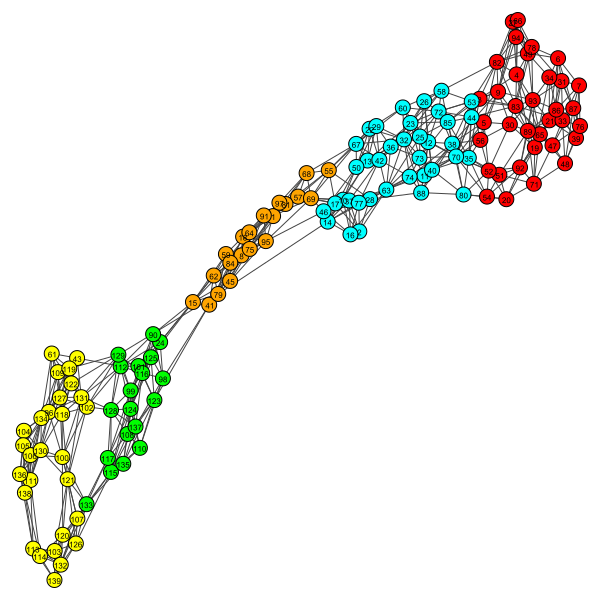

In [17]:
'''Andrew Y. Ng algorithm (K-eigenvector algorithm) communities on Weighted Adjacency matrix graph'''

#Set colors for clustering analysis
color_list_Ng = ['orange','red','yellow','green','cyan','pink','gray', 'violet', 'purple', 'palegreen', 'skyblue', 'dodgerblue',]
Farrah_PG_adjacency_graph.vs["color"] = [color_list_Ng[i] for i in cluster_labels2]

#Get conductance value
#https://github.com/crisbodnar/regularised-spectral-clustering/blob/master/spectral_clustering.ipynb at line 216
conductance=[]
for cluster in np.unique(cluster_labels2):
        graph_nx = Farrah_PG_adjacency_graph.to_networkx()
        partition = np.ravel(cluster_labels2[cluster_labels2==cluster])
        try:
            conductance.append(nx.conductance(graph_nx, partition, weight='weight'))
        except:
            conductance.append(1)
max_conductance = np.max(conductance)
max_conductance_index = conductance.index(max_conductance)
print('------------------')
print('Conductance per cluster:', conductance)
print('Max Conductance = ', max_conductance)
print('Cluster with max conductance color = ', color_list_Ng[max_conductance_index])

Andrew_Ng_conductance_array = np.array([str('Andrew Ng'), int(max(cluster_labels2)+1), float(max_conductance)], dtype=object)
Conductance_array[5] = Andrew_Ng_conductance_array


#Calculate Modularity
Andrew_Ng_clustering = VertexClustering(Farrah_PG_adjacency_graph, cluster_labels2)
Andrew_Ng_Modularity = Andrew_Ng_clustering.modularity
print("Modularity = ", Andrew_Ng_Modularity)
AndrewNg_modularity_array = np.array([str('Andrew Ng'), int(max(cluster_labels2)+1), float(Andrew_Ng_Modularity)], dtype=object)
Modularity_array[5] = AndrewNg_modularity_array

AndrewNg_clusters=cluster_labels2
print('Andrew Ng clusters = ',AndrewNg_clusters)

out_name = "5PCs_Farrah_PG_Andrew_Ng_graph.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

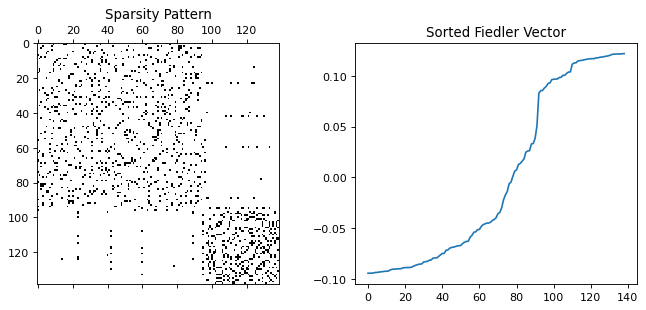

In [18]:
#Find communities based on Fiedler Vector (line 14 from link below):
#https://github.com/bionascu/graph-spectra/blob/master/graph-spectra.ipynb

# Construct diagonal matrix D
D = np.diag(np.sum(Adjacency_matrix, axis=1))

# Construct Laplacian matrix L
L = D - Adjacency_matrix

# Get eigenvalues in ascending order
w, X = scipy.linalg.eigh(L) 

# Get Fiedler Vector: The eigenvector corresponding to second smallest eigenvalue of L
fv = X[:, 1]

# Plot the sparsity pattern and sorted fiedler vector
fig=pyplot.figure(figsize=(10, 4), dpi= 80, facecolor='w', edgecolor='k')
pyplot.subplot(1,2,1)
pyplot.spy(Adjacency_matrix) 
pyplot.title('Sparsity Pattern')
pyplot.subplot(1,2,2)
pyplot.plot(np.sort(fv))
pyplot.title('Sorted Fiedler Vector')
pyplot.show()

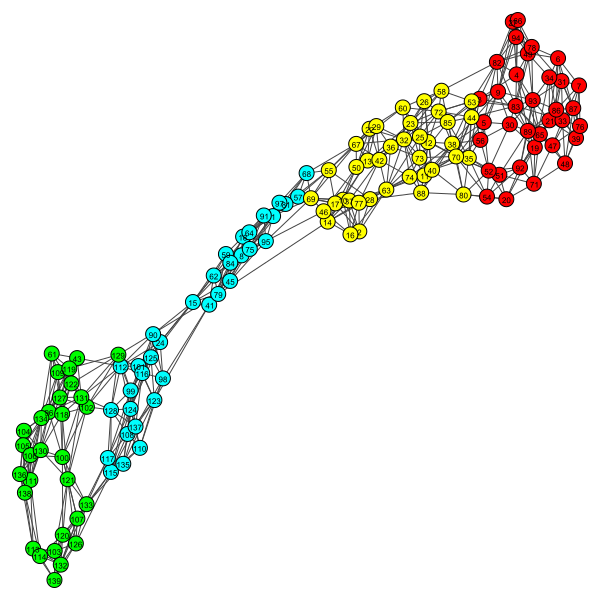

In [19]:
'''
Shi & Malik Spectral Clustering algorithm: Clusters = 4
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html
'''

#labels = SpectralClustering(KPCA_affinity_matrix, n_clusters=4, assign_labels='kmeans')
labels = SpectralClustering(n_clusters = 4, affinity = 'precomputed').fit(Adjacency_matrix).labels_

Shi_Malik_4_clusters = labels

Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in labels]

out_name = "5PCs_Farrah_PG_Shi_Malik_graph_4clusters.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

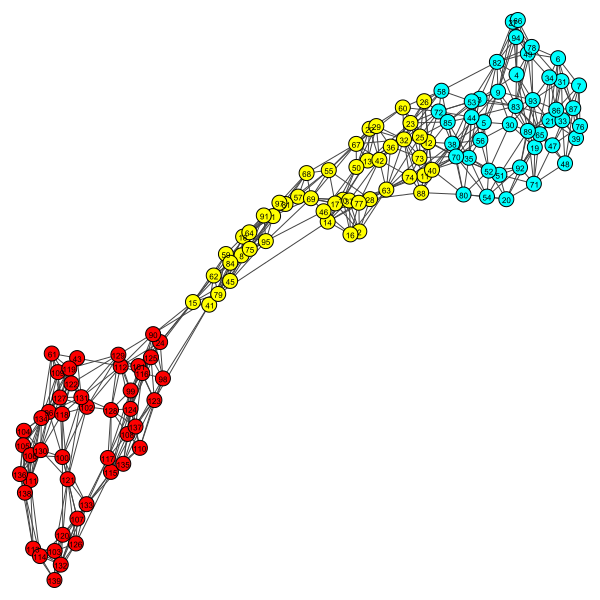

In [20]:
'''
Shi & Malik Spectral Clustering algorithm: Clusters = 3
'''

labels = SpectralClustering(n_clusters = 3, affinity = 'precomputed').fit(Adjacency_matrix).labels_



Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in labels]
out_name = "5PCs_Farrah_PG_Shi_Malik_graph_3clusters.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
Shi & Malik 5 clusters:
------------------
Conductance per cluster: [0.025641025641025664, 0.030303030303030283, 0.03333333333333332, 0.05882352941176472, 0.04999999999999998]
Max Conductance =  0.05882352941176472
Cluster with max conductance color =  green
Modularity =  0.6899791929939394
Shi & Malik - 5 clusters =  [4 0 0 1 1 1 1 4 1 0 0 0 0 0 4 0 0 4 1 1 1 0 0 3 0 0 1 0 0 1 1 0 1 1 0 0 0
 0 1 0 4 0 2 0 4 0 1 1 1 0 1 1 0 1 4 0 4 0 4 0 2 4 0 4 1 1 0 4 4 0 1 0 0 0
 4 1 0 1 4 0 4 1 1 4 0 1 1 0 1 3 4 1 1 1 4 2 4 3 3 2 3 2 2 2 2 2 2 3 2 3 2
 3 2 2 3 3 3 2 2 2 2 2 3 3 3 2 2 3 2 2 2 2 2 2 3 2 3 2 2]


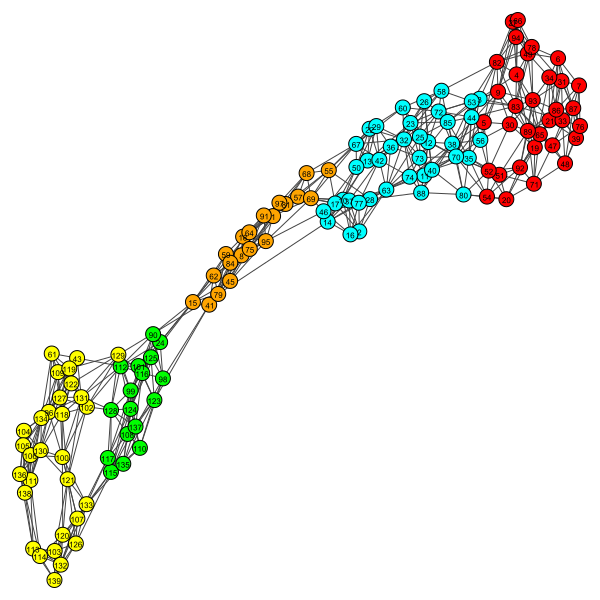

In [39]:
'''
Shi & Malik Spectral Clustering algorithm: Clusters = 5
'''

labels = SpectralClustering(n_clusters = 5, affinity = 'precomputed').fit(Adjacency_matrix).labels_

Shi_Malik_5_clusters = labels

#Get conductance value
#https://github.com/crisbodnar/regularised-spectral-clustering/blob/master/spectral_clustering.ipynb at line 216
conductance=[]
for cluster in np.unique(Shi_Malik_5_clusters):
        graph_nx = Farrah_PG_adjacency_graph.to_networkx()
        partition = np.ravel(Shi_Malik_5_clusters[labels==cluster])
        try:
            conductance.append(nx.conductance(graph_nx, partition, weight='weight'))
        except:
            conductance.append(1)
max_conductance = np.max(conductance)
max_conductance_index = conductance.index(max_conductance)
print('------------------')
print('Shi & Malik 5 clusters:')
print('------------------')
print('Conductance per cluster:', conductance)
print('Max Conductance = ', max_conductance)
print('Cluster with max conductance color = ', color_list[max_conductance_index])

Shi_Malik_conductance_array = np.array([str('Shi & Malik'), int(max(labels)+1), float(max_conductance)], dtype=object)
Conductance_array[6] = Shi_Malik_conductance_array



#Calculate Modularity
Shi_Malik_clustering = VertexClustering(Farrah_PG_adjacency_graph, labels)
Shi_Malik_Modularity = Shi_Malik_clustering.modularity
print("Modularity = ", Shi_Malik_Modularity)
Shi_Malik_modularity_array = np.array([str('Shi & Malik'), int(max(labels)+1), float(Shi_Malik_Modularity)], dtype=object)
Modularity_array[6] = Shi_Malik_modularity_array

Shi_Malik_5clusters=labels
print('Shi & Malik - 5 clusters = ',Shi_Malik_5clusters)

Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in Shi_Malik_5_clusters]
out_name = "5PCs_Farrah_PG_Shi_Malik_graph_5clusters.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

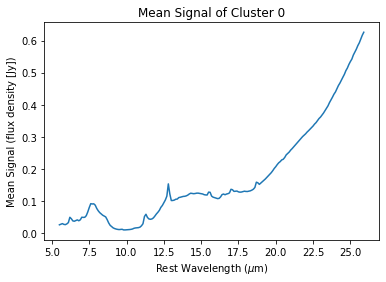

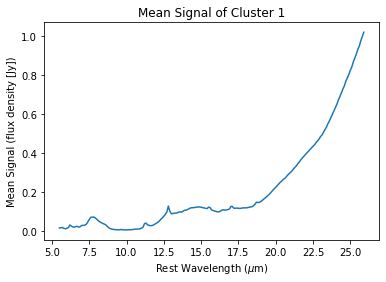

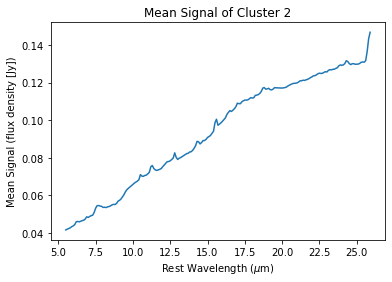

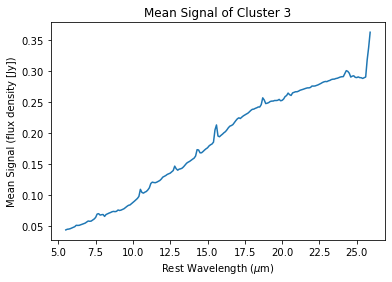

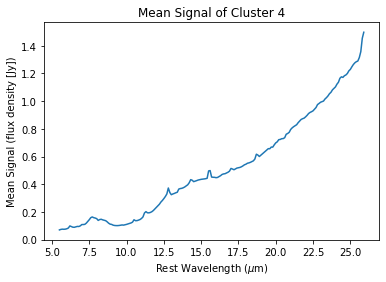

In [40]:
'''
Calculate and plot Mean Signals of each Shi & Malik cluster (5 clusters)
Use interpolated fluxes in "interpolated_fluxes_Farrah_PG". Each column = wavelength bin between: 5.5-26.0 microns (205 bins).
First find and remove 5 rows of double galaxies to get 139 rows.
'''

Shi_Malik_5_clusters = labels

clusters_and_names = tuple(zip(Shi_Malik_5_clusters,galaxy_names))


with open('interpolated_fluxes_Farrah_PG.csv', 'r') as f:
    #Read csv and append to list of lists
    reader = csv.reader(line.replace('\t',',') for line in f)
    data_list = list(reader)
    #Remove headers list from above
    interpolated_data = [elem[:-1] for elem in data_list[1:]]
    IR_luminosities = [elem[-1] for elem in data_list[1:]]
    
    
    #Create empty cluster signals arrays
    Cluster_Signal_0=np.empty((1,205))
    Cluster_Signal_1=np.empty((1,205))
    Cluster_Signal_2=np.empty((1,205))
    Cluster_Signal_3=np.empty((1,205))
    Cluster_Signal_4=np.empty((1,205))
    #Counters for number of galaxies in each cluster:
    counter_0 = 0
    counter_1 = 0
    counter_2 = 0
    counter_3 = 0
    counter_4 = 0
    #Lists of galaxy names for each cluster
    cluster_0 = []
    cluster_1 = []
    cluster_2 = []
    cluster_3 = []
    cluster_4 = []
    
    #Iterate over interpolated data list of lists:
    for i,line in enumerate(interpolated_data):
        for element in clusters_and_names:
            #Check if galaxy name matches between list of clusters and interpolated data:
            if element[1] == str(line[0]):
                #Select only data points, without galaxy names
                data_points = np.array(line[1:])
                data_points = data_points.astype(np.float32)    #change array type to float
                #Add interpolated data to cluster signals if cluster matches
                if element[0] == 0:
                    Cluster_Signal_0 = np.vstack([Cluster_Signal_0,data_points])
                    cluster_0.append(float(IR_luminosities[i]))
                    counter_0 += 1
                if element[0] == 1:
                    Cluster_Signal_1 = np.vstack([Cluster_Signal_1,data_points])
                    cluster_1.append(float(IR_luminosities[i]))
                    counter_1 += 1
                if element[0] == 2:
                    Cluster_Signal_2 = np.vstack([Cluster_Signal_2,data_points])
                    cluster_2.append(float(IR_luminosities[i]))
                    counter_2 += 1
                if element[0] == 3:
                    Cluster_Signal_3 = np.vstack([Cluster_Signal_3,data_points])
                    cluster_3.append(float(IR_luminosities[i]))
                    counter_3 += 1
                if element[0] == 4:
                    Cluster_Signal_4 = np.vstack([Cluster_Signal_4,data_points])
                    cluster_4.append(float(IR_luminosities[i]))
                    counter_4 += 1


#Delete empty data from list creation
Cluster_Signal_0 = np.delete(Cluster_Signal_0, 0, 0)
Cluster_Signal_1 = np.delete(Cluster_Signal_1, 0, 0)
Cluster_Signal_2 = np.delete(Cluster_Signal_2, 0, 0)
Cluster_Signal_3 = np.delete(Cluster_Signal_3, 0, 0)
Cluster_Signal_4 = np.delete(Cluster_Signal_4, 0, 0)


#Calculate mean signal of each cluster
Mean_Signal_0 = np.mean(Cluster_Signal_0, axis=0)
Mean_Signal_1 = np.mean(Cluster_Signal_1, axis=0)
Mean_Signal_2 = np.mean(Cluster_Signal_2, axis=0)
Mean_Signal_3 = np.mean(Cluster_Signal_3, axis=0)
Mean_Signal_4 = np.mean(Cluster_Signal_4, axis=0)

#Array of wavelengths (bins of interpolation)
wavelength_array = np.arange(5.5,26.0,0.1)


#Calculate mean IR luminosity of each cluster
cluster_0_mean_lum = statistics.mean(cluster_0)
cluster_1_mean_lum = statistics.mean(cluster_1)
cluster_2_mean_lum = statistics.mean(cluster_2)
cluster_3_mean_lum = statistics.mean(cluster_3)
cluster_4_mean_lum = statistics.mean(cluster_4)


#Plot Mean Signals

#Mean Signal 0
pyplot.plot(wavelength_array, Mean_Signal_0)
pyplot.xlabel('Rest Wavelength ($\mu$m)')
pyplot.ylabel('Mean Signal (flux density [Jy])')
pyplot.title('Mean Signal of Cluster 0')
pyplot.savefig('Mean_Signal_0.png', format='png', dpi=300)
pyplot.show()

#Mean Signal 1
pyplot.plot(wavelength_array, Mean_Signal_1)
pyplot.xlabel('Rest Wavelength ($\mu$m)')
pyplot.ylabel('Mean Signal (flux density [Jy])')
pyplot.title('Mean Signal of Cluster 1')
pyplot.savefig('Mean_Signal_1.png', format='png', dpi=300)
pyplot.show()

#Mean Signal 2
pyplot.plot(wavelength_array, Mean_Signal_2)
pyplot.xlabel('Rest Wavelength ($\mu$m)')
pyplot.ylabel('Mean Signal (flux density [Jy])')
pyplot.title('Mean Signal of Cluster 2')
pyplot.savefig('Mean_Signal_2.png', format='png', dpi=300)
pyplot.show()

#Mean Signal 3
pyplot.plot(wavelength_array, Mean_Signal_3)
pyplot.xlabel('Rest Wavelength ($\mu$m)')
pyplot.ylabel('Mean Signal (flux density [Jy])')
pyplot.title('Mean Signal of Cluster 3')
pyplot.savefig('Mean_Signal_3.png', format='png', dpi=300)
pyplot.show()

#Mean Signal 4
pyplot.plot(wavelength_array, Mean_Signal_4)
pyplot.xlabel('Rest Wavelength ($\mu$m)')
pyplot.ylabel('Mean Signal (flux density [Jy])')
pyplot.title('Mean Signal of Cluster 4')
pyplot.savefig('Mean_Signal_4.png', format='png', dpi=300)
pyplot.show()

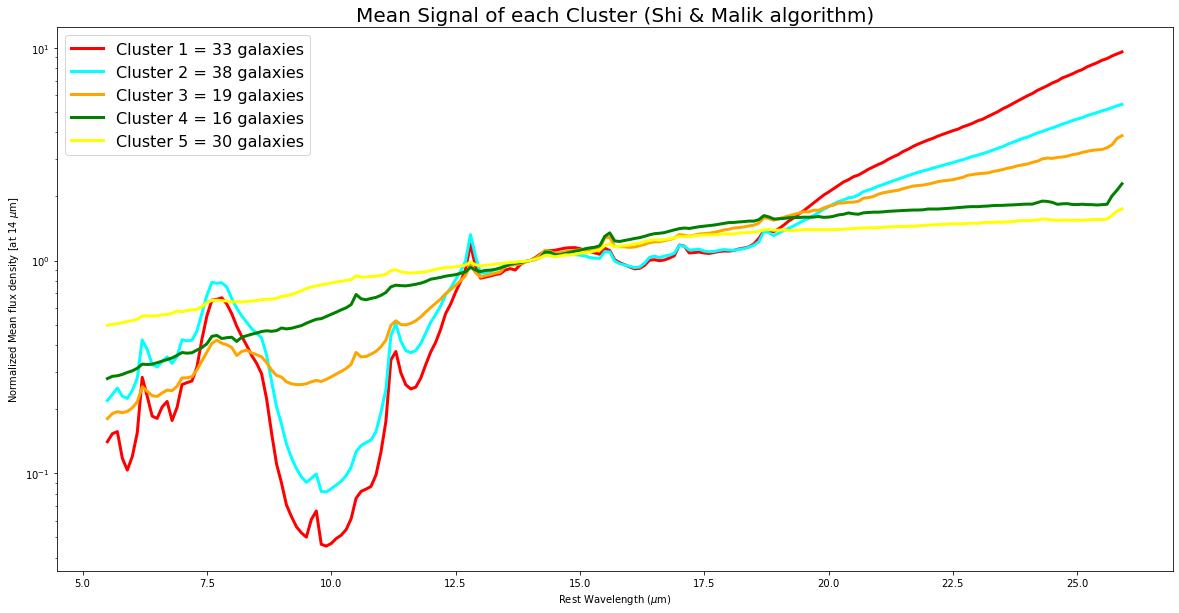

In [41]:
#Plot Mean Signals of each Shi & Malik cluster (above) in a single plot

#Normalize/equalize flux at 14 microns for all signals
flux_norm_value_0 = float(Mean_Signal_0[85]) #85th element = wavelength at 14 microns
flux_norm_value_1 = float(Mean_Signal_1[85])
flux_norm_value_2 = float(Mean_Signal_2[85])
flux_norm_value_3 = float(Mean_Signal_3[85])
flux_norm_value_4 = float(Mean_Signal_4[85])

Mean_Signal_norm_0 = Mean_Signal_0/flux_norm_value_0
Mean_Signal_norm_1 = Mean_Signal_1/flux_norm_value_1
Mean_Signal_norm_2 = Mean_Signal_2/flux_norm_value_2
Mean_Signal_norm_3 = Mean_Signal_3/flux_norm_value_3
Mean_Signal_norm_4 = Mean_Signal_4/flux_norm_value_4


#Mean Signal Plot
pyplot.figure(figsize=(20,10))
pyplot.plot(wavelength_array, Mean_Signal_norm_1, color='red', linewidth=3, label='Cluster 1 = %.0f galaxies' %counter_1)
pyplot.plot(wavelength_array, Mean_Signal_norm_0, color='cyan', linewidth=3, label='Cluster 2 = %.0f galaxies' %counter_0)
pyplot.plot(wavelength_array, Mean_Signal_norm_4, color='orange', linewidth=3, label='Cluster 3 = %.0f galaxies' %counter_4)
pyplot.plot(wavelength_array, Mean_Signal_norm_3, color='green', linewidth=3, label='Cluster 4 = %.0f galaxies' %counter_3)
pyplot.plot(wavelength_array, Mean_Signal_norm_2, color='yellow', linewidth=3, label='Cluster 5 = %.0f galaxies' %counter_2)
pyplot.rc('font', size=16) 
pyplot.rc('axes', titlesize=20)
pyplot.rc('axes', labelsize=16)
pyplot.rc('xtick', labelsize=16)
pyplot.rc('ytick', labelsize=16)
pyplot.legend(loc='upper left')
pyplot.yscale('log')
pyplot.xlabel('Rest Wavelength ($\mu$m)')
pyplot.ylabel('Normalized Mean flux density [at 14 $\mu$m]')
pyplot.title('Mean Signal of each Cluster (Shi & Malik algorithm)')
pyplot.savefig('Mean_Signals.png', format='png', dpi=300)
pyplot.show()

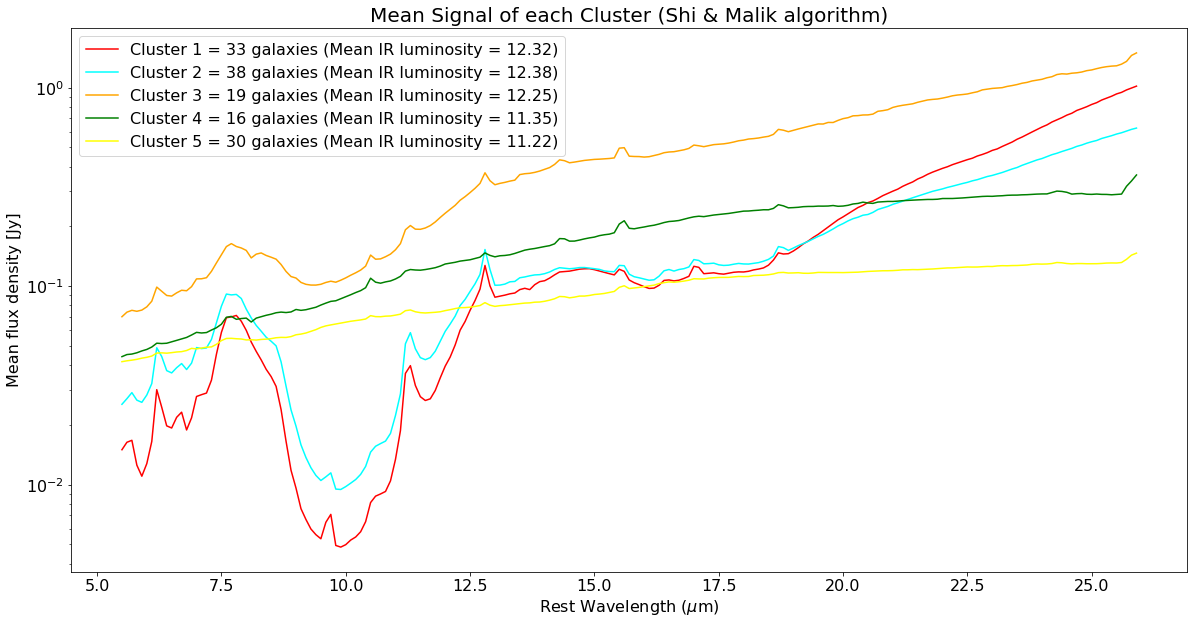

In [42]:
#Plot Mean Signals of each Shi & Malik cluster (above) in a single plot - WITH MEAN LUMINOSITIES

#Mean Signal Plot
pyplot.figure(figsize=(20,10))
pyplot.plot(wavelength_array, Mean_Signal_1, color='red', label='Cluster 1 = %.0f galaxies (Mean IR luminosity = %.2f)' %(counter_1,cluster_1_mean_lum))
pyplot.plot(wavelength_array, Mean_Signal_0, color='cyan', label='Cluster 2 = %.0f galaxies (Mean IR luminosity = %.2f)' %(counter_0,cluster_0_mean_lum))
pyplot.plot(wavelength_array, Mean_Signal_4, color='orange', label='Cluster 3 = %.0f galaxies (Mean IR luminosity = %.2f)' %(counter_4,cluster_4_mean_lum))
pyplot.plot(wavelength_array, Mean_Signal_3, color='green', label='Cluster 4 = %.0f galaxies (Mean IR luminosity = %.2f)' %(counter_3,cluster_3_mean_lum))
pyplot.plot(wavelength_array, Mean_Signal_2, color='yellow', label='Cluster 5 = %.0f galaxies (Mean IR luminosity = %.2f)' %(counter_2,cluster_2_mean_lum))
pyplot.rc('font', size=16) 
pyplot.rc('axes', titlesize=20)
pyplot.rc('axes', labelsize=16)
pyplot.rc('xtick', labelsize=16)
pyplot.rc('ytick', labelsize=16)
pyplot.legend(loc='upper left')
pyplot.yscale('log')
pyplot.xlabel('Rest Wavelength ($\mu$m)')
pyplot.ylabel('Mean flux density [Jy]')
pyplot.title('Mean Signal of each Cluster (Shi & Malik algorithm)')
pyplot.savefig('Mean_Signals_luminosities.png', format='png', dpi=300)
pyplot.show()

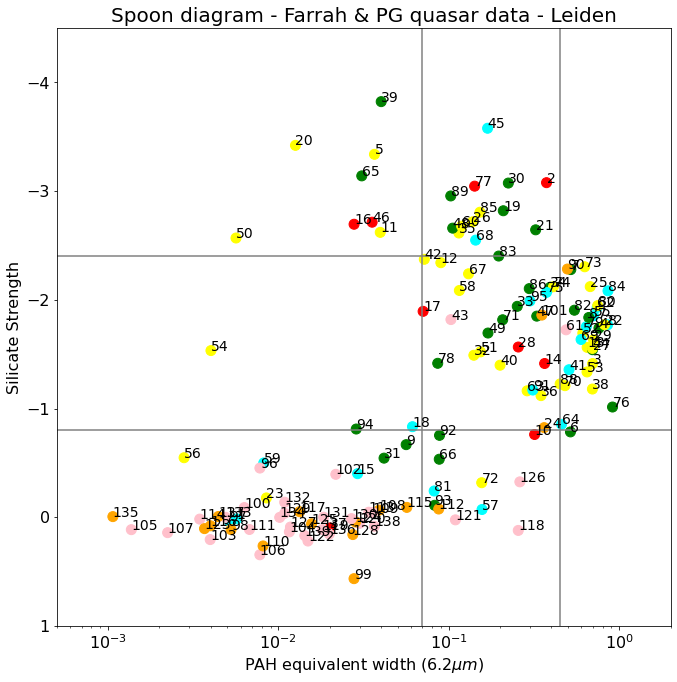

In [43]:
'''
Create Fork diagram plot similar to Spoon et al (2007), Fig. 1 - Leiden clusters
'''

with open('PAH_Si.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        PAH_ew62=[]
        Silicate_Strength=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[0]))
            PAH_ew62.append(float(elems[1]))
            Silicate_Strength.append(float(elems[6]))
            

cluster_colors = np.squeeze([color_list[i] for i in leiden_labels])
#Plot Fork diagram
pyplot.figure(figsize=(11,11))
pyplot.scatter(PAH_ew62,Silicate_Strength, s=100, color=cluster_colors)
pyplot.xscale("log")
pyplot.ylim(-4.5,1.0)
pyplot.xlim(0.0005,2.0)
pyplot.xlabel("PAH equivalent width $(6.2 \mu m)$")
pyplot.ylabel("Silicate Strength")
#Annotations:
for i, txt in enumerate(x[0] for x in labels_list):
#    if txt=='3C273'or txt=='Arp220' or txt=='IRAS08572+3915' or txt=='IRAS18030+0705':
#        pyplot.annotate(txt, (PAH_ew62[i], Silicate_Strength[i]), clip_on=True, color='blue', fontsize=8)
#    else:
        pyplot.annotate(txt, (PAH_ew62[i], Silicate_Strength[i]), clip_on=True, fontsize=14)
pyplot.gca().invert_yaxis()
#Custom grid lines
pyplot.axvline(x=0.07, color='grey', ls='-')
pyplot.axvline(x=0.45, color='grey', ls='-')
pyplot.axhline(y=-0.8, color='grey', ls='-')
pyplot.axhline(y=-2.4, color='grey', ls='-')
#pyplot.grid(True)
pyplot.title("Spoon diagram - Farrah & PG quasar data - Leiden")
pyplot.savefig('Spoon_diagram_KPCA_Leiden.png', format='png', dpi=300)
pyplot.show()

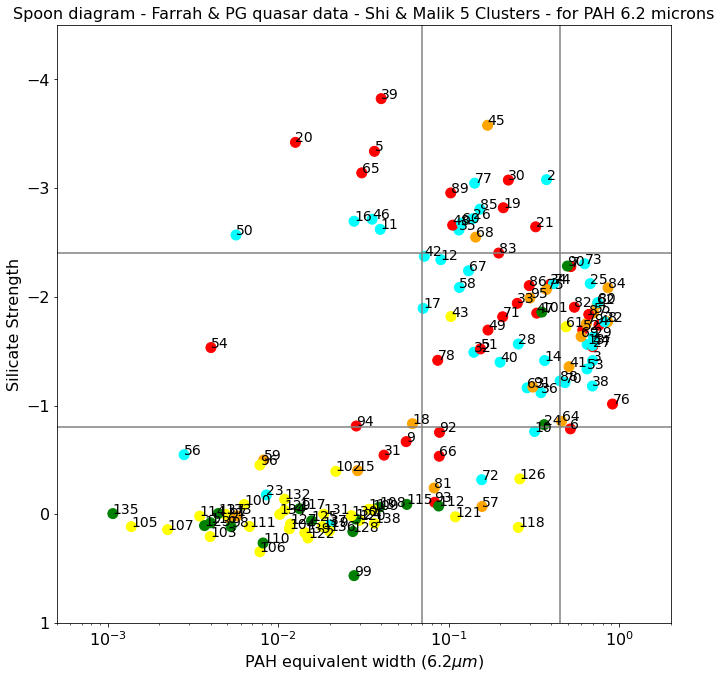

In [44]:
'''
Create Fork diagram plot similar to Spoon et al (2007), Fig. 1 - Shi & Malik 5 clusters - for PAH 6.2 microns
'''

with open('PAH_Si.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        PAH_ew62=[]
        Silicate_Strength=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[0]))
            PAH_ew62.append(float(elems[1]))
            Silicate_Strength.append(float(elems[6]))
            

cluster_colors = np.squeeze([color_list[i] for i in Shi_Malik_5_clusters])
#Plot Fork diagram
pyplot.figure(figsize=(11,11))
pyplot.scatter(PAH_ew62,Silicate_Strength, s=100, color=cluster_colors)
pyplot.xscale("log")
pyplot.ylim(-4.5,1.0)
pyplot.xlim(0.0005,2.0)
pyplot.xlabel("PAH equivalent width $(6.2 \mu m)$")
pyplot.ylabel("Silicate Strength")
#Annotations:
for i, txt in enumerate(x[0] for x in labels_list):
#    if txt=='3C273'or txt=='Arp220' or txt=='IRAS08572+3915' or txt=='IRAS18030+0705':
#        pyplot.annotate(txt, (PAH_ew62[i], Silicate_Strength[i]), clip_on=True, color='blue', fontsize=8)
#    else:
        pyplot.annotate(txt, (PAH_ew62[i], Silicate_Strength[i]), clip_on=True, fontsize=14)
pyplot.gca().invert_yaxis()
#Font sizes
pyplot.rc('font', size=16) 
pyplot.rc('axes', titlesize=16)
pyplot.rc('axes', labelsize=18)
pyplot.rc('xtick', labelsize=16)
pyplot.rc('ytick', labelsize=16)
#Custom grid lines
pyplot.axvline(x=0.07, color='grey', ls='-')
pyplot.axvline(x=0.45, color='grey', ls='-')
pyplot.axhline(y=-0.8, color='grey', ls='-')
pyplot.axhline(y=-2.4, color='grey', ls='-')
#pyplot.grid(True)
pyplot.title("Spoon diagram - Farrah & PG quasar data - Shi & Malik 5 Clusters - for PAH 6.2 microns")
pyplot.savefig('Spoon_diagram_KPCA_Shi_Malik_5_clusters_PAH_6.2.png', format='png', dpi=300)
pyplot.show()

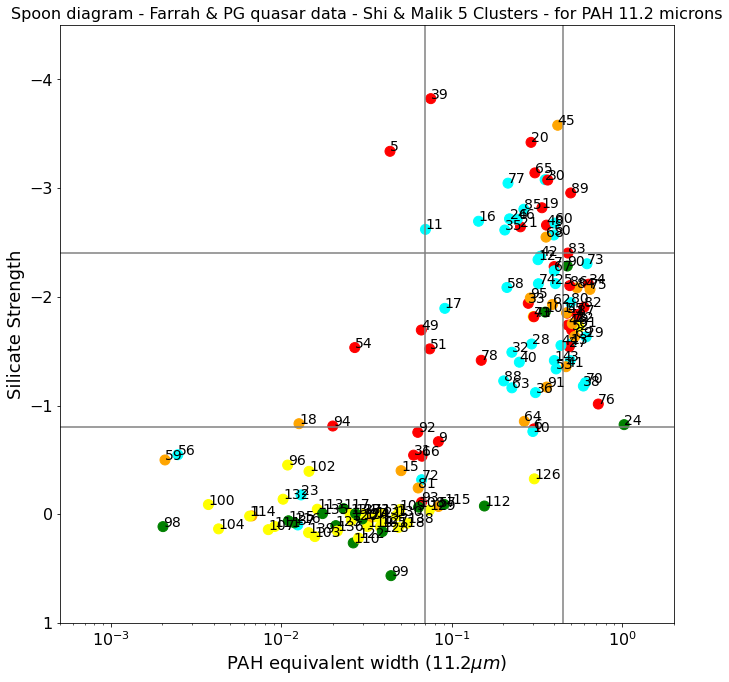

In [45]:
'''
Create Fork diagram plot similar to Spoon et al (2007), Fig. 1 - Shi & Malik 5 clusters - for PAH 11.2 microns
'''

with open('PAH_Si.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        PAH_ew11=[]
        Silicate_Strength=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[0]))
            PAH_ew11.append(float(elems[3]))
            Silicate_Strength.append(float(elems[6]))
            

cluster_colors = np.squeeze([color_list[i] for i in Shi_Malik_5_clusters])
#Plot Fork diagram
pyplot.figure(figsize=(11,11))
pyplot.scatter(PAH_ew11,Silicate_Strength, s=100, color=cluster_colors)
pyplot.xscale("log")
pyplot.ylim(-4.5,1.0)
pyplot.xlim(0.0005,2.0)
pyplot.xlabel("PAH equivalent width $(11.2 \mu m)$")
pyplot.ylabel("Silicate Strength")
#Annotations:
for i, txt in enumerate(x[0] for x in labels_list):
#    if txt=='3C273'or txt=='Arp220' or txt=='IRAS08572+3915' or txt=='IRAS18030+0705':
#        pyplot.annotate(txt, (PAH_ew62[i], Silicate_Strength[i]), clip_on=True, color='blue', fontsize=8)
#    else:
        pyplot.annotate(txt, (PAH_ew11[i], Silicate_Strength[i]), clip_on=True, fontsize=14)
pyplot.gca().invert_yaxis()
#Font sizes
pyplot.rc('font', size=16) 
pyplot.rc('axes', titlesize=16)
pyplot.rc('axes', labelsize=18)
pyplot.rc('xtick', labelsize=16)
pyplot.rc('ytick', labelsize=16)
#Custom grid lines
pyplot.axvline(x=0.07, color='grey', ls='-')
pyplot.axvline(x=0.45, color='grey', ls='-')
pyplot.axhline(y=-0.8, color='grey', ls='-')
pyplot.axhline(y=-2.4, color='grey', ls='-')
#pyplot.grid(True)
pyplot.title("Spoon diagram - Farrah & PG quasar data - Shi & Malik 5 Clusters - for PAH 11.2 microns")
pyplot.savefig('Spoon_diagram_KPCA_Shi_Malik_5_clusters_PAH_11.2.png', format='png', dpi=300)
pyplot.show()

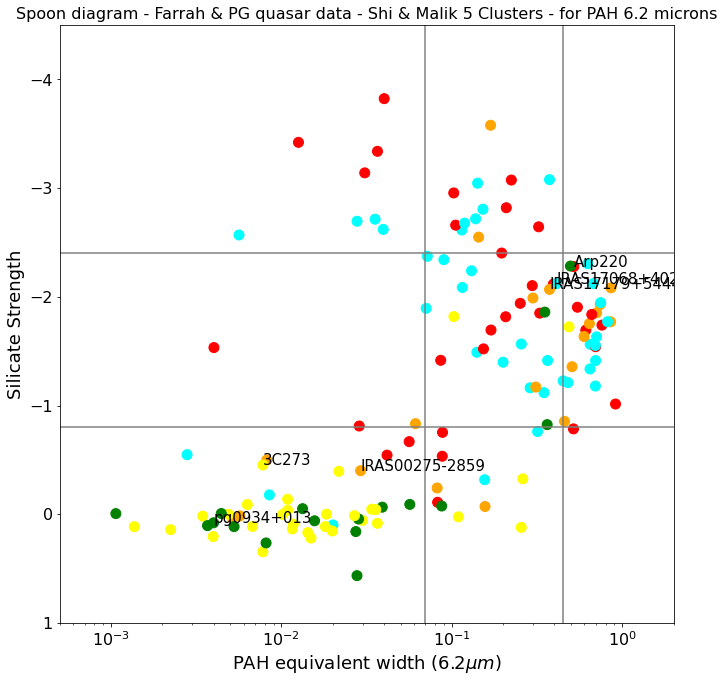

In [46]:
'''
Create Fork diagram plot again ONLY FOR ARCHETYPICAL GALAXIES - Shi & Malik 5 clusters - for PAH 6.2 microns
'''

with open('PAH_Si.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        PAH_ew62=[]
        Silicate_Strength=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[0]))
            PAH_ew62.append(float(elems[1]))
            Silicate_Strength.append(float(elems[6]))
            



#Read names
with open('./Labels_5PCs_Gaussian.csv','r', encoding="latin-1") as names_file:
    names = list(csv.reader(names_file))
names_file.close()

galaxy_names_array = np.array(names[0])
names_list=[]
for i,elem in enumerate(galaxy_names_array):
    names_list.append(elem.split('.')[0])

galaxy_names = np.array(names_list)

            
cluster_colors = np.squeeze([color_list[i] for i in Shi_Malik_5_clusters])
#Plot Fork diagram
pyplot.figure(figsize=(11,11))
pyplot.scatter(PAH_ew62,Silicate_Strength, s=100, color=cluster_colors)
pyplot.xscale("log")
pyplot.ylim(-4.5,1.0)
pyplot.xlim(0.0005,2.0)
pyplot.xlabel("PAH equivalent width $(6.2 \mu m)$")
pyplot.ylabel("Silicate Strength")
#Annotations:
for i, txt in enumerate(x for x in galaxy_names):
    if txt=='3C273' or txt=='Arp220' or txt=='IRAS17068+4027' or txt=='IRAS17179+5444' or txt=='IRAS00275-2859' or txt=='pg0934+013':
        pyplot.annotate(txt, (PAH_ew62[i], Silicate_Strength[i]), clip_on=True, fontsize=15)
    else:
        pass
#        pyplot.annotate(txt, (PAH_ew62[i], Silicate_Strength[i]), clip_on=True, fontsize=14)
pyplot.gca().invert_yaxis()
#Custom grid lines
pyplot.axvline(x=0.07, color='grey', ls='-')
pyplot.axvline(x=0.45, color='grey', ls='-')
pyplot.axhline(y=-0.8, color='grey', ls='-')
pyplot.axhline(y=-2.4, color='grey', ls='-')
#pyplot.grid(True)
pyplot.title("Spoon diagram - Farrah & PG quasar data - Shi & Malik 5 Clusters - for PAH 6.2 microns")
pyplot.savefig('Spoon_diagram_KPCA_Shi_Malik_5_clusters_PAH_6.2_archetypical.png', format='png', dpi=300)
pyplot.show()

------------------
LEIDEN algorithm - PAH sizes:
------------------
Number of communities:  5
Resolution parameter = 0.8
Modularity score =  0.6870805546168828


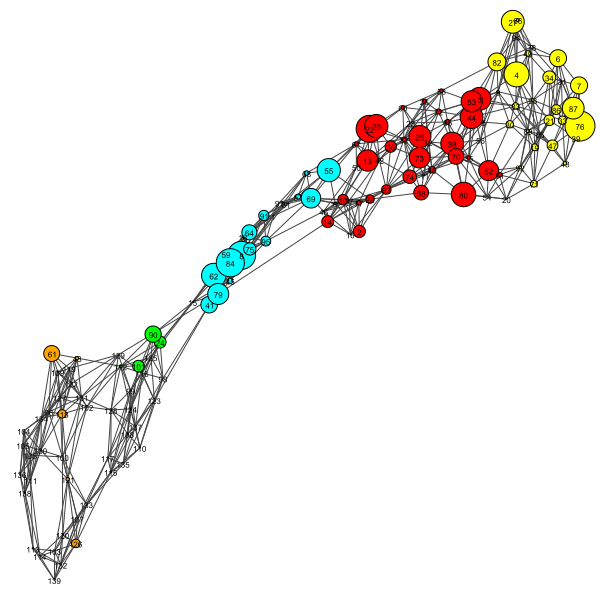

In [47]:
'''
Use Normalized PAH & Si to create node sizes in clustering graphs - Leiden
'''

with open('PAH_Si_Normalized.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        PAH_ew62_norm=[]
        Silicate_Strength_norm=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[0]))
            PAH_ew62_norm.append(float(elems[1]))
            Silicate_Strength_norm.append(float(elems[3]))
            
PAH_sizes = [i*30 for i in PAH_ew62_norm]

Si_sizes = [i*30 for i in Silicate_Strength_norm]


print('------------------')
print('LEIDEN algorithm - PAH sizes:')
print('------------------')

#objective_function = sets highest modularity as target
#resolution_parameter = sets resolution (higher = more communities)
communities = Farrah_PG_adjacency_graph.community_leiden(objective_function='modularity',weights=Farrah_PG_adjacency_graph.es['weight'], resolution_parameter=0.8)
print('Number of communities: ', max(communities.membership)+1)
print('Resolution parameter = 0.8')
print('Modularity score = ',communities.modularity)
leiden_labels = communities.membership
Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in communities.membership]
out_name = "5PCs_Farrah_PG_Leiden_PAH.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = PAH_sizes)

------------------
LEIDEN algorithm - Silicate sizes:
------------------
Number of communities:  5
Resolution parameter = 0.8
Modularity score =  0.6870805546168828


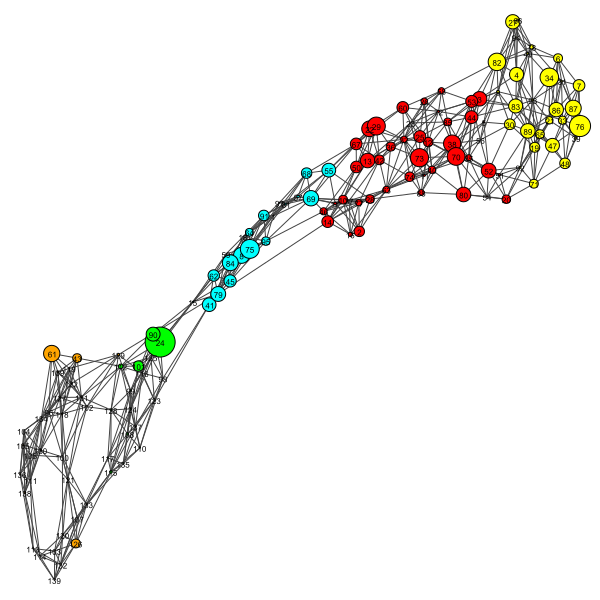

In [48]:
print('------------------')
print('LEIDEN algorithm - Silicate sizes:')
print('------------------')
print('Number of communities: ', max(communities.membership)+1)
print('Resolution parameter = 0.8')
print('Modularity score = ',communities.modularity)

out_name = "5PCs_Farrah_PG_Leiden_Si.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = Si_sizes)

------------------
Shi & Malik algorithm (5 clusters) - PAH sizes:
------------------


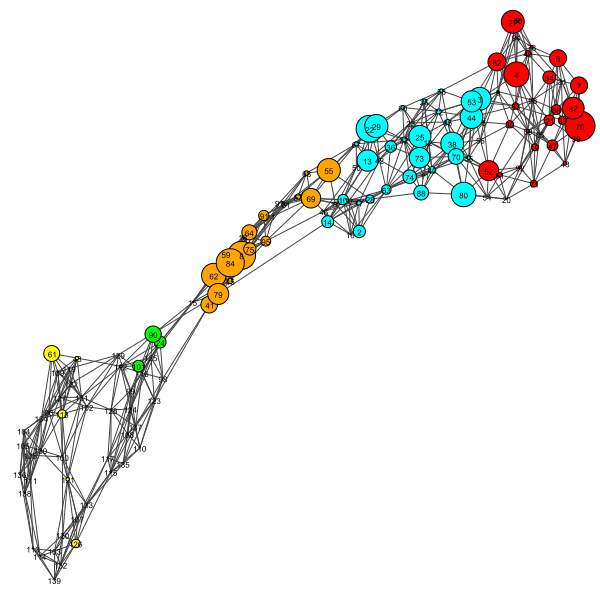

In [49]:
'''
Use Normalized PAH & Si to create node sizes in clustering graphs - Shi & Malik
'''

with open('PAH_Si_Normalized.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        PAH_ew62_norm=[]
        Silicate_Strength_norm=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[0]))
            PAH_ew62_norm.append(float(elems[1]))
            Silicate_Strength_norm.append(float(elems[3]))
            
PAH_sizes = [i*30 for i in PAH_ew62_norm]

Si_sizes = [i*30 for i in Silicate_Strength_norm]


print('------------------')
print('Shi & Malik algorithm (5 clusters) - PAH sizes:')
print('------------------')


Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in Shi_Malik_5_clusters]
out_name = "5PCs_Farrah_PG_Shi_Malik_graph_5clusters_PAH.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = PAH_sizes)

------------------
Shi & Malik algorithm (5 clusters) - Silicate sizes:
------------------


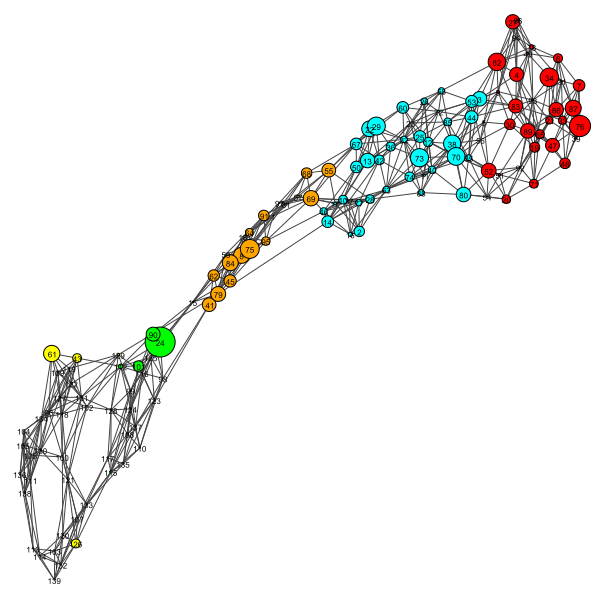

In [50]:
print('------------------')
print('Shi & Malik algorithm (5 clusters) - Silicate sizes:')
print('------------------')

out_name = "5PCs_Farrah_PG_Shi_Malik_graph_5clusters_Si.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = Si_sizes)

In [51]:
'''
Rank all modularity-based algorithms based on their modularity (high-to-low)
'''

print('Modularity algorithm, number of clusters, modularity score')
sorted_Modularity_array = np.argsort(Modularity_array[:,2])[::-1]
print(Modularity_array[sorted_Modularity_array])
np.savetxt("Modularity_array.csv", Modularity_array[sorted_Modularity_array], delimiter=",", fmt="%s")

Modularity algorithm, number of clusters, modularity score
[['Walktrap' 6 0.7012495882156984]
 ['Louvain' 6 0.6974439367131324]
 ['Leiden' 6 0.6970102890155834]
 ['Girvan-Newman' 6 0.6965437914617221]
 ['Shi & Malik' 5 0.6899791929939394]
 ['Andrew Ng' 5 0.6841718644367417]
 ['Newman' 6 0.6711224903470854]]


In [52]:
'''
Rank all algorithms performance based on their max conductance (low-to-high)
'''

print('Algorithm, number of clusters, max conductance')
sorted_Conductance_array = np.argsort(Conductance_array[:,2])
print(Conductance_array[sorted_Conductance_array])
np.savetxt("Conductance_array.csv", Conductance_array[sorted_Conductance_array], delimiter=",", fmt="%s")

Algorithm, number of clusters, max conductance
[['Andrew Ng' 5 0.05263157894736843]
 ['Shi & Malik' 5 0.05882352941176472]
 ['Walktrap' 6 0.21039943345138076]
 ['Louvain' 6 0.22098115504261895]
 ['Girvan-Newman' 6 0.22098115504261895]
 ['Newman' 6 0.22885569990778815]
 ['Leiden' 6 0.2879560007477289]]


-------------
PAH colormap:
-------------


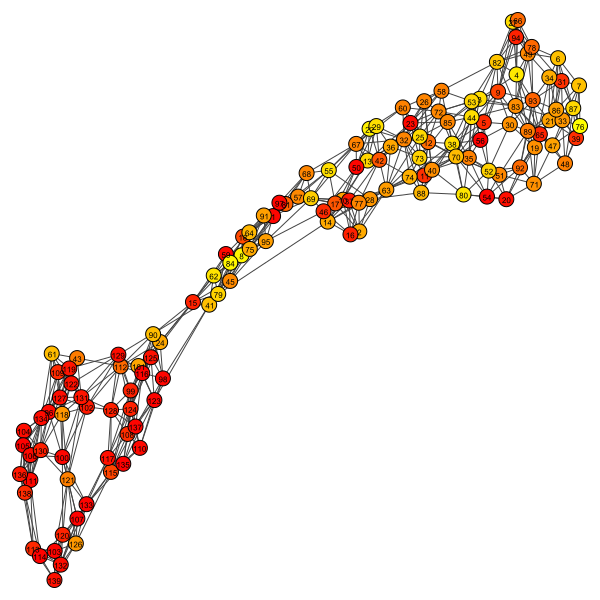

In [53]:
'''
PAH 6.2 distribution = colormap (heatmap)
'''

with open('PAH_Si_Normalized.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        PAH_ew62_norm=[]
        Silicate_Strength_norm=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[0]))
            PAH_ew62_norm.append(float(elems[1]))
            Silicate_Strength_norm.append(float(elems[3]))

#Colormap method based on: https://stackoverflow.com/questions/28752727/map-values-to-colors-in-matplotlib
PAH_min = min(PAH_ew62_norm)
PAH_max = max(PAH_ew62_norm)
PAH_mean = statistics.median(PAH_ew62_norm)
PAH_norm = colors.TwoSlopeNorm(vmin = PAH_min, vcenter=PAH_mean, vmax = PAH_max)
PAH_mapper = cm.ScalarMappable(norm=PAH_norm,cmap=cm.get_cmap('autumn'))


Si_min = min(Silicate_Strength_norm)
Si_max = max(Silicate_Strength_norm)
Si_mean = statistics.median(Silicate_Strength_norm)
Si_norm = colors.TwoSlopeNorm(vmin = Si_min, vcenter=Si_mean, vmax = Si_max)
Si_mapper = cm.ScalarMappable(norm=Si_norm,cmap=cm.get_cmap('autumn'))


print('-------------')
print('PAH colormap:')
print('-------------')

Farrah_PG_adjacency_graph.vs["color"] = [PAH_mapper.to_rgba(i) for i in PAH_ew62_norm]
out_name = "5PCs_Farrah_PG_PAH_6.2_colormap.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

-------------
PAH colormap:
-------------


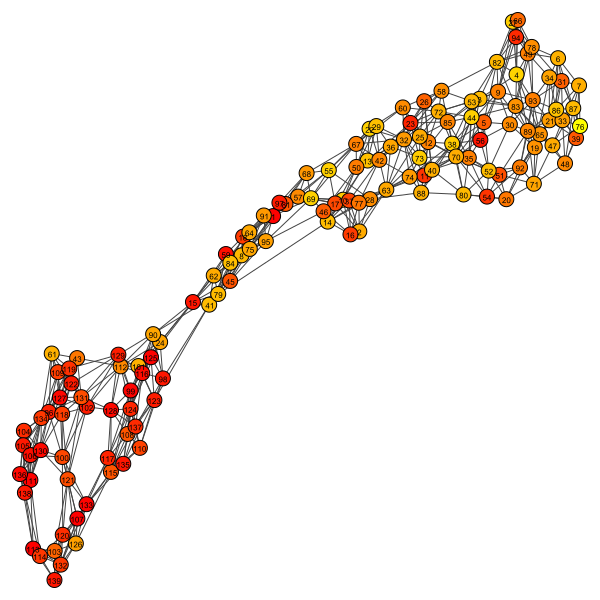

In [54]:
'''
PAH 11.2 distribution = colormap (heatmap)
'''

with open('PAH_Si_Normalized.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        PAH_ew11_norm=[]
        Silicate_Strength_norm=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[0]))
            PAH_ew11_norm.append(float(elems[2]))
            Silicate_Strength_norm.append(float(elems[3]))

#Colormap method based on: https://stackoverflow.com/questions/28752727/map-values-to-colors-in-matplotlib
PAH_min = min(PAH_ew11_norm)
PAH_max = max(PAH_ew11_norm)
PAH_mean = statistics.median(PAH_ew11_norm)
PAH_norm = colors.TwoSlopeNorm(vmin = PAH_min, vcenter=PAH_mean, vmax = PAH_max)
PAH_mapper = cm.ScalarMappable(norm=PAH_norm,cmap=cm.get_cmap('autumn'))


Si_min = min(Silicate_Strength_norm)
Si_max = max(Silicate_Strength_norm)
Si_mean = statistics.median(Silicate_Strength_norm)
Si_norm = colors.TwoSlopeNorm(vmin = Si_min, vcenter=Si_mean, vmax = Si_max)
Si_mapper = cm.ScalarMappable(norm=Si_norm,cmap=cm.get_cmap('autumn'))


print('-------------')
print('PAH colormap:')
print('-------------')

Farrah_PG_adjacency_graph.vs["color"] = [PAH_mapper.to_rgba(i) for i in PAH_ew11_norm]
out_name = "5PCs_Farrah_PG_PAH_11.2_colormap.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------------
Silicate depth colormap:
------------------------


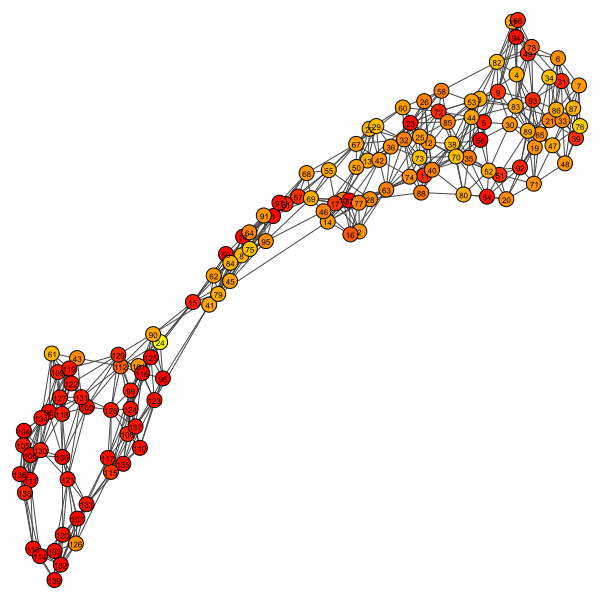

In [55]:
'''
Silicate distribution = colormap (heatmap)
'''


print('------------------------')
print('Silicate depth colormap:')
print('------------------------')

Farrah_PG_adjacency_graph.vs["color"] = [Si_mapper.to_rgba(i) for i in Silicate_Strength_norm]
out_name = "5PCs_Farrah_PG_Si_colormap.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
Graph using Nuclear Separation as color:
------------------


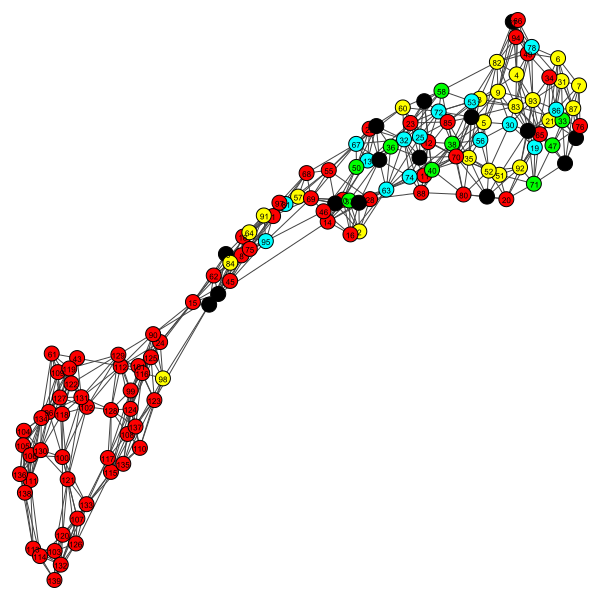

In [56]:
'''
Graph with Nuclear Separation as colors (no data = black color)
'''

with open('farrah_original_data.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        nuclear_separation=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[1]))
            nuclear_separation.append(int(elems[10]))
            
#Fill in missing data (for Symeonidis PG quasars) to get red color = single nucleus (quasars)
x=1
while x<38:
    nuclear_separation.append(int(1))   
    x+=1

print('------------------')
print('Graph using Nuclear Separation as color:')
print('------------------')

#Set colors for clustering analysis = same as Farrah (2009)
#Black = no data, red = single nucleus (<0.1kpc), yellow = 0.1-6 kpc, green = 6-12 kpc, blue = >12kpc
color_list = ['black','red','yellow','yellow','yellow','green','green', 'cyan', 'cyan', 'cyan','black', 'skyblue', 'dodgerblue']

Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in nuclear_separation]
out_name = "5PCs_Farrah_PG_graph_Nuclear_Separation.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
Graph using Optical Spectral Type as color:
------------------


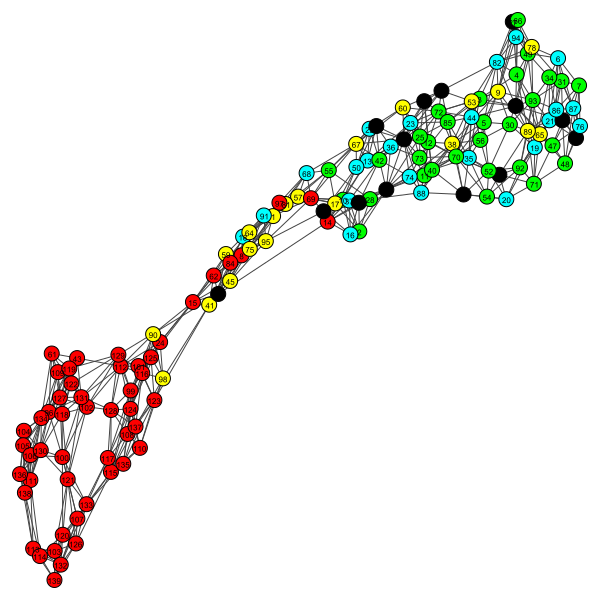

In [57]:
'''
Graph with Optical Spectral Type as colors (no data = black color)
'''

with open('farrah_original_data.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        optical_spectral_type=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[1]))
            optical_spectral_type.append(int(elems[8]))
            
#Fill in missing data (for Symeonidis PG quasars) to get black color
x=1
while x<38:
    optical_spectral_type.append(int(4))   #sample = all quasars
    x+=1

print('------------------')
print('Graph using Optical Spectral Type as color:')
print('------------------')

#Set colors for clustering analysis = same as Farrah (2009)
color_list = ['black','cyan','green','yellow','red','pink','gray', 'violet', 'purple','black', 'palegreen', 'skyblue', 'dodgerblue']

Farrah_PG_adjacency_graph.vs["color"] = [color_list[i] for i in optical_spectral_type]
out_name = "5PCs_Farrah_PG_graph_Optical_Spectral_Type.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
Graph using Nuclear Separation as colormap:
------------------


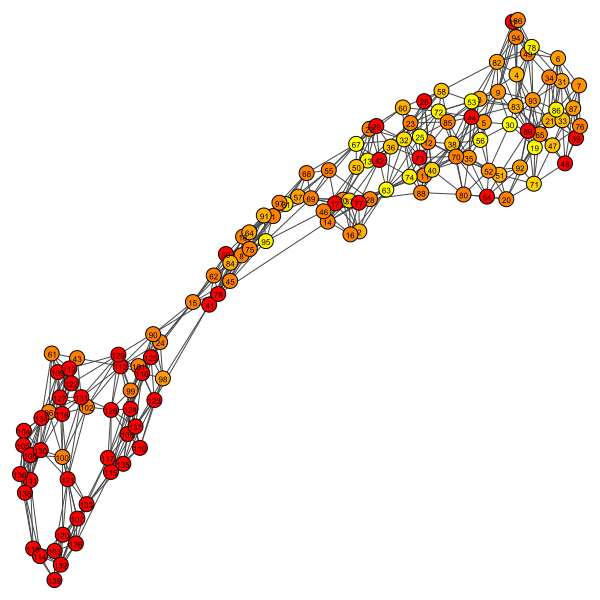

In [58]:
'''
Graph with Nuclear Separation as colormap (no data = red color)
'''

with open('farrah_original_data.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        nuclear_separation=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[1]))
            nuclear_separation.append(int(elems[10]))
            
#Fill in missing data (for Symeonidis PG quasars) to get black color
x=1
while x<38:
    nuclear_separation.append(int(0))   
    x+=1

print('------------------')
print('Graph using Nuclear Separation as colormap:')
print('------------------')

#Set colors for clustering analysis
#color_list = ['black','mintcream','aquamarine','springgreen','lime','limegreen','green', 'olive', 'darkolivegreen', 'darkgreen','black', 'skyblue', 'dodgerblue']
#color_list = ['black','navy','mediumblue','blue','royalblue','deepskyblue','cyan', 'paleturquoise', 'lightcyan', 'azure','black', 'skyblue', 'dodgerblue']

#Create colormap for nuclear separation categories (lighter color = higher separation)
nuclear_min = 0
nuclear_max = 9
nuclear_mean = 1
nuclear_norm = colors.TwoSlopeNorm(vmin = nuclear_min, vcenter=nuclear_mean, vmax = nuclear_max)
nuclear_mapper = cm.ScalarMappable(norm=nuclear_norm,cmap=cm.get_cmap('autumn'))

Farrah_PG_adjacency_graph.vs["color"] = [nuclear_mapper.to_rgba(i) for i in nuclear_separation]
out_name = "5PCs_Farrah_PG_graph_Nuclear_Separation_colormap.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
Graph using Optical Spectral Type as colormap:
------------------


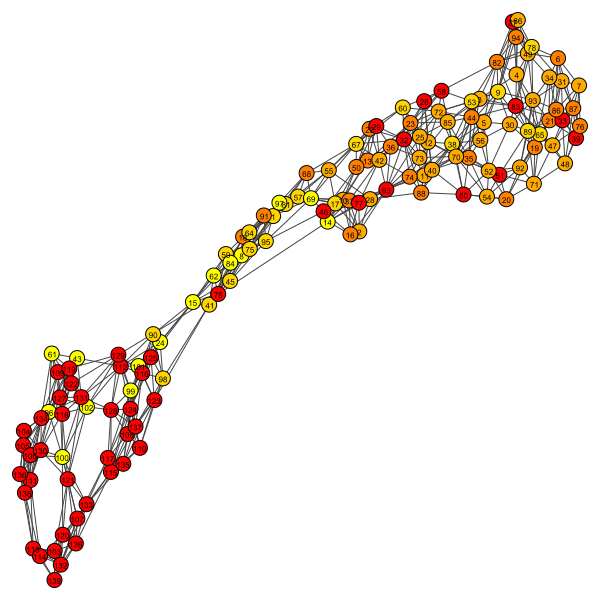

In [59]:
'''
Graph with Optical Spectral Type as colormap (no data = red color)
'''

with open('farrah_original_data.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        optical_spectral_type=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[1]))
            optical_spectral_type.append(int(elems[8]))
            
#Fill in missing data (for Symeonidis PG quasars) to get red color
x=1
while x<38:
    optical_spectral_type.append(int(0))   
    x+=1

print('------------------')
print('Graph using Optical Spectral Type as colormap:')
print('------------------')

#Set colors for clustering analysis
#color_list = ['cyan','red','yellow','green','orange','pink','gray', 'violet', 'purple','black', 'palegreen', 'skyblue', 'dodgerblue']

#Create colormap for nuclear separation categories (lighter color = higher separation)
optical_min = 0
optical_max = 4
optical_mean = 1
optical_norm = colors.TwoSlopeNorm(vmin = optical_min, vcenter=optical_mean, vmax = optical_max)
optical_mapper = cm.ScalarMappable(norm=optical_norm,cmap=cm.get_cmap('autumn'))

Farrah_PG_adjacency_graph.vs["color"] = [optical_mapper.to_rgba(i) for i in optical_spectral_type]
out_name = "5PCs_Farrah_PG_graph_Optical_Spectral_Type_colormap.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

------------------
Graph using Total IR Luminosity as colormap:
------------------


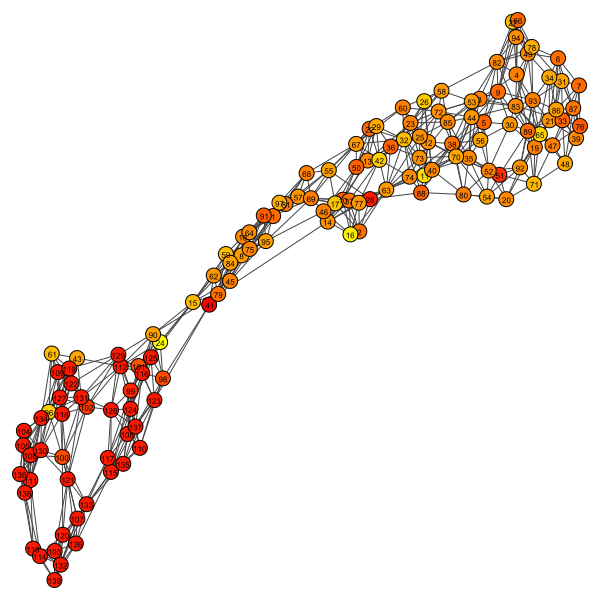

In [60]:
'''
Graph with Total IR Luminosity as colormap (no data = red color)
'''

with open('farrah_original_data.txt', 'r') as f:
        reader = f.readlines() 
        names=[]
        IR_lum=[]
        #Skip first line in file:
        for line in reader[1:]:
            elems = line.strip(' ').split()
            names.append(str(elems[1]))
            IR_lum.append(float(elems[12]))
            
#Fill in missing data (for Symeonidis PG quasars)
x=1
while x<38:
    IR_lum.append(float(11.0))   
    x+=1

print('------------------')
print('Graph using Total IR Luminosity as colormap:')
print('------------------')

#Set colors for clustering analysis
#color_list = ['cyan','red','yellow','green','orange','pink','gray', 'violet', 'purple','black', 'palegreen', 'skyblue', 'dodgerblue']

IR_luminosity = [math.exp(x) for x in IR_lum]

#Create colormap for Total IR Luminosity
IR_luminosity_min = min(IR_luminosity)
IR_luminosity_max = max(IR_luminosity)
IR_luminosity_mean = statistics.median(IR_luminosity)
IR_luminosity_norm = colors.TwoSlopeNorm(vmin = IR_luminosity_min, vcenter=IR_luminosity_mean, vmax = IR_luminosity_max)
IR_luminosity_mapper = cm.ScalarMappable(norm=IR_luminosity_norm,cmap=cm.get_cmap('autumn'))

Farrah_PG_adjacency_graph.vs["color"] = [IR_luminosity_mapper.to_rgba(i) for i in IR_luminosity]
out_name = "5PCs_Farrah_PG_graph_IR_luminosity_colormap.png"
plot(Farrah_PG_adjacency_graph, out_name, layout=custom_layout, vertex_size = 15)

In [61]:
'''
Compare lists of clusters detected by algorithms:
Try to find similarity between clusters detected by each algorithm by comparing the cluster of each node.
'''

#Blondel(Louvain) vs Girvan-Newman comparison:
counter=0
Louvain_vs_Girvan_Newman=[None]*139
for i,elem in enumerate(Louvain_clusters):
    if elem==Girvan_Newman_clusters[i]:
        Louvain_vs_Girvan_Newman[i]=1
        counter+=1
    else:
        Louvain_vs_Girvan_Newman[i]=0

print('Blondel(Louvain) vs Girvan-Newman comparison:')
print(Louvain_vs_Girvan_Newman)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(Louvain_clusters,Girvan_Newman_clusters))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))




#Blondel(Louvain) vs Leiden comparison:
counter=0
Louvain_vs_Leiden=[None]*139
for i,elem in enumerate(Louvain_clusters):
    if elem==leiden_labels[i]:
        Louvain_vs_Leiden[i]=1
        counter+=1
    else:
        Louvain_vs_Leiden[i]=0

print('--------------------------------------')
print('Blondel(Louvain) vs Leiden comparison:')
print(Louvain_vs_Leiden)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(Louvain_clusters,leiden_labels))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))




#Blondel(Louvain) vs Leiden comparison:
counter=0
Louvain_vs_Newman=[None]*139
for i,elem in enumerate(Louvain_clusters):
    if elem==Newman_clusters[i]:
        Louvain_vs_Newman[i]=1
        counter+=1
    else:
        Louvain_vs_Newman[i]=0

print('--------------------------------------')
print('Blondel(Louvain) vs Newman comparison:')
print(Louvain_vs_Newman)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(Louvain_clusters,Newman_clusters))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))




#Blondel(Louvain) vs Walktrap comparison:
counter=0
Louvain_vs_Walktrap=[None]*139
for i,elem in enumerate(Louvain_clusters):
    if elem==Walktrap_clusters[i]:
        Louvain_vs_Walktrap[i]=1
        counter+=1
    else:
        Louvain_vs_Walktrap[i]=0

print('--------------------------------------')
print('Blondel(Louvain) vs Walktrap comparison:')
print(Louvain_vs_Walktrap)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(Louvain_clusters,Walktrap_clusters))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))





#Girvan-Newman vs Leiden comparison:
counter=0
Girvan_Newman_vs_Leiden=[None]*139
for i,elem in enumerate(Girvan_Newman_clusters):
    if elem==leiden_labels[i]:
        Girvan_Newman_vs_Leiden[i]=1
        counter+=1
    else:
        Girvan_Newman_vs_Leiden[i]=0

print('--------------------------------------')
print('Girvan-Newman vs Leiden comparison:')
print(Girvan_Newman_vs_Leiden)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(Girvan_Newman_clusters,leiden_labels))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))





#Girvan-Newman vs Newman comparison:
counter=0
Girvan_Newman_vs_Newman=[None]*139
for i,elem in enumerate(Girvan_Newman_clusters):
    if elem==Newman_clusters[i]:
        Girvan_Newman_vs_Newman[i]=1
        counter+=1
    else:
        Girvan_Newman_vs_Newman[i]=0

print('--------------------------------------')
print('Girvan-Newman vs Newman comparison:')
print(Girvan_Newman_vs_Newman)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(Girvan_Newman_clusters,Newman_clusters))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))






#Girvan-Newman vs Walktrap comparison:
counter=0
Girvan_Newman_vs_Walktrap=[None]*139
for i,elem in enumerate(Girvan_Newman_clusters):
    if elem==Walktrap_clusters[i]:
        Girvan_Newman_vs_Walktrap[i]=1
        counter+=1
    else:
        Girvan_Newman_vs_Walktrap[i]=0

print('--------------------------------------')
print('Girvan-Newman vs Walktrap comparison:')
print(Girvan_Newman_vs_Walktrap)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(Girvan_Newman_clusters,Walktrap_clusters))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))






#Leiden vs Newman comparison:
counter=0
Leiden_vs_Newman=[None]*139
for i,elem in enumerate(leiden_labels):
    if elem==Newman_clusters[i]:
        Leiden_vs_Newman[i]=1
        counter+=1
    else:
        Leiden_vs_Newman[i]=0

print('--------------------------------------')
print('Leiden vs Newman comparison:')
print(Leiden_vs_Newman)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(leiden_labels,Newman_clusters))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))






#Leiden vs Walktrap comparison:
counter=0
Leiden_vs_Walktrap=[None]*139
for i,elem in enumerate(leiden_labels):
    if elem==Walktrap_clusters[i]:
        Leiden_vs_Walktrap[i]=1
        counter+=1
    else:
        Leiden_vs_Walktrap[i]=0

print('--------------------------------------')
print('Leiden vs Walktrap comparison:')
print(Leiden_vs_Walktrap)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(leiden_labels,Walktrap_clusters))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))






#Leiden vs Shi&Malik comparison:
counter=0
Leiden_vs_ShiMalik=[None]*139
for i,elem in enumerate(leiden_labels):
    if elem==Shi_Malik_5clusters[i]:
        Leiden_vs_ShiMalik[i]=1
        counter+=1
    else:
        Leiden_vs_ShiMalik[i]=0

print('--------------------------------------')
print('Leiden vs Shi&Malik(5 clusters) comparison:')
print(Leiden_vs_ShiMalik)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(leiden_labels,Shi_Malik_5clusters))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))






#Newman vs Walktrap comparison:
counter=0
Newman_vs_Walktrap=[None]*139
for i,elem in enumerate(Newman_clusters):
    if elem==Walktrap_clusters[i]:
        Newman_vs_Walktrap[i]=1
        counter+=1
    else:
        Newman_vs_Walktrap[i]=0

print('--------------------------------------')
print('Newman vs Walktrap comparison:')
print(Newman_vs_Walktrap)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(Newman_clusters,Walktrap_clusters))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))





#Andrew Ng vs Shi&Malik comparison:
counter=0
AndrewNg_vs_ShiMalik=[None]*139
for i,elem in enumerate(AndrewNg_clusters):
    if elem==Shi_Malik_5clusters[i]:
        AndrewNg_vs_ShiMalik[i]=1
        counter+=1
    else:
        AndrewNg_vs_ShiMalik[i]=0

print('--------------------------------------')
print('Andrew Ng vs Shi&Malik(5 clusters) comparison:')
print(AndrewNg_vs_ShiMalik)
#print('Similarity = ',"{0:.0f}%".format(counter/139*100))
#Find position matches between clusters in 2 algorithms
positionMatches = sum(a==b for a,b in zip(AndrewNg_clusters,Shi_Malik_5clusters))
print('Position matches = ', positionMatches)
print('Similarity = ', "{0:.0f}%".format(positionMatches/139*100))

Blondel(Louvain) vs Girvan-Newman comparison:
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]
Position matches =  136
Similarity =  98%
--------------------------------------
Blondel(Louvain) vs Leiden comparison:
[1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [62]:
'''Compare communities (clusters) detected by different algorithms using "compare_communities" from igraph'''
#See: https://igraph.org/python/api/latest/igraph.clustering.html#compare_communities


print('Comparison between communities using igraphs "compare_communities":')
print('Method = Normalized Mutual Information (nmi)')
print(' ')


#Modularity algorithms:

print('Modularity algorithms:')
print('-------------------------------')


Louvain_vs_Girvan_Newman = compare_communities(Louvain_clusters,Girvan_Newman_clusters, method='nmi', remove_none=False)
print('Blondel(Louvain) vs Girvan-Newman comparison = ', Louvain_vs_Girvan_Newman)

Louvain_vs_Leiden = compare_communities(Louvain_clusters,leiden_labels, method='nmi', remove_none=False)
print('Blondel(Louvain) vs Leiden comparison = ', Louvain_vs_Leiden)

Louvain_vs_Newman = compare_communities(Louvain_clusters,Newman_clusters, method='nmi', remove_none=False)
print('Blondel(Louvain) vs Newman comparison = ', Louvain_vs_Newman)

Louvain_vs_Walktrap = compare_communities(Louvain_clusters,Walktrap_clusters, method='nmi', remove_none=False)
print('Blondel(Louvain) vs Walktrap comparison = ', Louvain_vs_Walktrap)

Louvain_vs_Andrew_Ng = compare_communities(Louvain_clusters,AndrewNg_clusters, method='nmi', remove_none=False)
print('Blondel(Louvain) vs Andrew Ng comparison = ', Louvain_vs_Andrew_Ng)

Louvain_vs_Shi_Malik = compare_communities(Louvain_clusters,Shi_Malik_5clusters, method='nmi', remove_none=False)
print('Blondel(Louvain) vs Shi & Malik comparison = ', Louvain_vs_Shi_Malik)




Girvan_Newman_vs_Leiden = compare_communities(Girvan_Newman_clusters,leiden_labels, method='nmi', remove_none=False)
print('Girvan-Newman vs Leiden comparison = ', Girvan_Newman_vs_Leiden)

Girvan_Newman_vs_Newman = compare_communities(Girvan_Newman_clusters,Newman_clusters, method='nmi', remove_none=False)
print('Girvan-Newman vs Newman comparison = ', Girvan_Newman_vs_Newman)

Girvan_Newman_vs_Walktrap = compare_communities(Girvan_Newman_clusters,Walktrap_clusters, method='nmi', remove_none=False)
print('Girvan-Newman vs Walktrap comparison = ', Girvan_Newman_vs_Walktrap)

Girvan_Newman_vs_Andrew_Ng = compare_communities(Girvan_Newman_clusters,AndrewNg_clusters, method='nmi', remove_none=False)
print('Girvan-Newman vs Andrew Ng comparison = ', Girvan_Newman_vs_Andrew_Ng)

Girvan_Newman_vs_Shi_Malik = compare_communities(Girvan_Newman_clusters,Shi_Malik_5clusters, method='nmi', remove_none=False)
print('Girvan-Newman vs Shi & Malik comparison = ', Girvan_Newman_vs_Shi_Malik)




Leiden_vs_Newman = compare_communities(leiden_labels,Newman_clusters, method='nmi', remove_none=False)
print('Leiden vs Newman comparison = ', Leiden_vs_Newman)

Leiden_vs_Walktrap = compare_communities(leiden_labels,Walktrap_clusters, method='nmi', remove_none=False)
print('Leiden vs Walktrap comparison = ', Leiden_vs_Walktrap)

Leiden_vs_Andrew_Ng = compare_communities(leiden_labels,AndrewNg_clusters, method='nmi', remove_none=False)
print('Leiden vs Andrew Ng comparison = ', Leiden_vs_Andrew_Ng)

Leiden_vs_Shi_Malik = compare_communities(leiden_labels,Shi_Malik_5clusters, method='nmi', remove_none=False)
print('Leiden vs Shi & Malik comparison = ', Leiden_vs_Shi_Malik)





Newman_vs_Walktrap = compare_communities(Newman_clusters,Walktrap_clusters, method='nmi', remove_none=False)
print('Newman vs Walktrap comparison = ', Newman_vs_Walktrap)

Newman_vs_Andrew_Ng = compare_communities(Newman_clusters,AndrewNg_clusters, method='nmi', remove_none=False)
print('Newman vs Andrew Ng comparison = ', Newman_vs_Andrew_Ng)

Newman_vs_Shi_Malik = compare_communities(Newman_clusters,Shi_Malik_5clusters, method='nmi', remove_none=False)
print('Newman vs Shi & Malik comparison = ', Newman_vs_Shi_Malik)






Walktrap_vs_Andrew_Ng = compare_communities(Walktrap_clusters,AndrewNg_clusters, method='nmi', remove_none=False)
print('Walktrap vs Andrew Ng comparison = ', Walktrap_vs_Andrew_Ng)

Walktrap_vs_Shi_Malik = compare_communities(Walktrap_clusters,Shi_Malik_5clusters, method='nmi', remove_none=False)
print('Walktrap vs Andrew Ng comparison = ', Walktrap_vs_Shi_Malik)





print(' ')




#Spectral algorithms:

print('Spectral Graph algorithms:')
print('-------------------------------')


Andrew_Ng_vs_Shi_Malik = compare_communities(AndrewNg_clusters,Shi_Malik_5clusters, method='nmi', remove_none=False)
print('Andrew Ng vs Shi&Malik 5 clusters comparison = ', Andrew_Ng_vs_Shi_Malik)


Comparison between communities using igraphs "compare_communities":
Method = Normalized Mutual Information (nmi)
 
Modularity algorithms:
-------------------------------
Blondel(Louvain) vs Girvan-Newman comparison =  0.9537003044867303
Blondel(Louvain) vs Leiden comparison =  0.8854991693300418
Blondel(Louvain) vs Newman comparison =  0.8426900428086967
Blondel(Louvain) vs Walktrap comparison =  0.9195559196282836
Blondel(Louvain) vs Andrew Ng comparison =  0.8739219923448093
Blondel(Louvain) vs Shi & Malik comparison =  0.9235975285659901
Girvan-Newman vs Leiden comparison =  0.8871833646146767
Girvan-Newman vs Newman comparison =  0.8751027966515783
Girvan-Newman vs Walktrap comparison =  0.9212060514149433
Girvan-Newman vs Andrew Ng comparison =  0.8693642823016484
Girvan-Newman vs Shi & Malik comparison =  0.8830074714322425
Leiden vs Newman comparison =  0.8189590559556009
Leiden vs Walktrap comparison =  0.9016485140667455
Leiden vs Andrew Ng comparison =  0.8837382284907147
Lei

In [63]:
'''Create Table comparing Clustering Algorithms (Table 1 in Graph Theory paper)'''

#Create table comparing algorithms
table = [['ALGORITHM','Louvain','Girvan-Newman','Leiden','Newman','Walktrap','Andrew Ng','Shi & Malik'],
         ['Louvain',1,Louvain_vs_Girvan_Newman,Louvain_vs_Leiden,Louvain_vs_Newman,Louvain_vs_Walktrap,Louvain_vs_Andrew_Ng,Louvain_vs_Shi_Malik],
         ['Girvan-Newman',Louvain_vs_Girvan_Newman,1,Girvan_Newman_vs_Leiden,Girvan_Newman_vs_Newman,Girvan_Newman_vs_Walktrap,Girvan_Newman_vs_Andrew_Ng,Girvan_Newman_vs_Shi_Malik],
         ['Leiden',Louvain_vs_Leiden,Girvan_Newman_vs_Leiden,1,Leiden_vs_Newman,Leiden_vs_Walktrap,Leiden_vs_Andrew_Ng,Leiden_vs_Shi_Malik],
         ['Newman',Louvain_vs_Newman,Girvan_Newman_vs_Newman,Leiden_vs_Newman,1,Newman_vs_Walktrap,Newman_vs_Andrew_Ng,Newman_vs_Shi_Malik],
         ['Walktrap',Louvain_vs_Walktrap,Girvan_Newman_vs_Walktrap,Leiden_vs_Walktrap,Newman_vs_Walktrap,1,Walktrap_vs_Andrew_Ng,Walktrap_vs_Shi_Malik],
         ['Andrew Ng',Louvain_vs_Andrew_Ng,Girvan_Newman_vs_Andrew_Ng,Leiden_vs_Andrew_Ng,Newman_vs_Andrew_Ng,Walktrap_vs_Andrew_Ng,1,Andrew_Ng_vs_Shi_Malik],
         ['Shi & Malik',Louvain_vs_Shi_Malik,Girvan_Newman_vs_Shi_Malik,Leiden_vs_Shi_Malik,Newman_vs_Shi_Malik,Walktrap_vs_Shi_Malik,Andrew_Ng_vs_Shi_Malik,1]]


#Print table
print(tabulate(table, headers='firstrow', tablefmt='heavy_grid', floatfmt=".3f"))

#Save table as CSV
np.savetxt("Algorithms_comparison_table.csv", table, delimiter=",", fmt='%s')


┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ ALGORITHM     ┃   Louvain ┃   Girvan-Newman ┃   Leiden ┃   Newman ┃   Walktrap ┃   Andrew Ng ┃   Shi & Malik ┃
┣━━━━━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━┫
┃ Louvain       ┃     1.000 ┃           0.954 ┃    0.885 ┃    0.843 ┃      0.920 ┃       0.874 ┃         0.924 ┃
┣━━━━━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━┫
┃ Girvan-Newman ┃     0.954 ┃           1.000 ┃    0.887 ┃    0.875 ┃      0.921 ┃       0.869 ┃         0.883 ┃
┣━━━━━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━┫
┃ Leiden        ┃     0.885 ┃           0.887 ┃    1.000 ┃    0.819 ┃      0.902 ┃       0.884 ┃         0.932 ┃
┣━━━━━━━━━━━━━━━╋━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━━━╋━━━━━━━━━━━━━╋